https://github.com/pytorch/examples/blob/master/dcgan/main.py

In [57]:
from __future__ import print_function
import argparse
import os
import random
import numpy as np
import h5py
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
%matplotlib inline

In [58]:
# parser = argparse.ArgumentParser()
# parser.add_argument('--dataset', required=True, help='cifar10 | lsun | imagenet | folder | lfw | fake')
# parser.add_argument('--dataroot', required=True, help='path to dataset')
# parser.add_argument('--workers', type=int, help='number of data loading workers', default=2)
# parser.add_argument('--batchSize', type=int, default=64, help='input batch size')
# parser.add_argument('--imageSize', type=int, default=64, help='the height / width of the input image to network')
# parser.add_argument('--nz', type=int, default=100, help='size of the latent z vector')
# parser.add_argument('--ngf', type=int, default=64)
# parser.add_argument('--ndf', type=int, default=64)
# parser.add_argument('--niter', type=int, default=25, help='number of epochs to train for')
# parser.add_argument('--lr', type=float, default=0.0002, help='learning rate, default=0.0002')
# parser.add_argument('--beta1', type=float, default=0.5, help='beta1 for adam. default=0.5')
# parser.add_argument('--cuda', action='store_true', help='enables cuda')
# parser.add_argument('--ngpu', type=int, default=1, help='number of GPUs to use')
# parser.add_argument('--netG', default='', help="path to netG (to continue training)")
# parser.add_argument('--netD', default='', help="path to netD (to continue training)")
# parser.add_argument('--outf', default='.', help='folder to output images and model checkpoints')
# parser.add_argument('--manualSeed', type=int, help='manual seed')

# opt = parser.parse_args()
# print(opt)

In [59]:
# dataset = 
# dataroot = 

In [60]:
workers = 1
batchSize = 8
# imageSize = 128
nz = 1000        # 'size of the latent z vector'
ngf = 4         # dimension of the cube
ndf = 4         # dimension of the cube
niter = 25       # 'number of epochs to train for'
lr = 0.0002      # 'learning rate, default=0.0002'
beta1 = 0.5      # 'beta1 for adam. default=0.5'
cuda = True
ngpu = 1      
netG_arg = ""        # "path to netG (to continue training)"
netD_arg = ""        # "path to netD (to continue training)"
outf = "."       # 'folder to output images and model checkpoints'
manualSeed = 1   # 'manual seed'

n_samples = 2560 # number of subcubes to sample

In [61]:
try:
#     os.makedirs(opt.outf)
    os.makedirs(outf)
except OSError:
    pass

In [62]:
# if opt.manualSeed is None:
#     opt.manualSeed = random.randint(1, 10000)
# print("Random Seed: ", opt.manualSeed)
# random.seed(opt.manualSeed)
# torch.manual_seed(opt.manualSeed)

if manualSeed is None:
    manualSeed = random.randint(1, 10000)
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  1


In [63]:
if torch.cuda.is_available() and not opt.cuda:
    print("WARNING: You have a CUDA device, so you should probably run with --cuda")

In [64]:
# dataset

In [65]:
def define_test(s_test, s_train):
    #2048/16=128
    m=8
    x=random.randint(0,m)*s_train
    y=random.randint(0,m)*s_train
    z=random.randint(0,m)*s_train
    #print(x,y,z)
    return {'x':[x,x+s_test], 'y':[y,y+s_test], 'z':[z,z+s_test]}

def check_coords(test_coords, train_coords):
    valid=True
    for i in ['x','y','z']:
        r=(max(test_coords[i][0], 
               train_coords[i][0]), 
           min(test_coords[i][1],
               train_coords[i][1]))
        if r[0]<=r[1]:
            valid=False
    return valid

def get_samples(s_sample, nsamples, redshift, test_coords):
    #n is size of minibatch, get valid samples (not intersecting with test_coords)
    sample_list=[]
    m=2048-128
    for n in range(nsamples):
        #print("Sample No = " + str(n + 1) + " / " + str(nsamples))
        sample_valid=False
        while sample_valid==False:
            x = random.randint(0,m)
            y = random.randint(0,m)
            z = random.randint(0,m)
            sample_coords = {'x':[x,x+s_sample], 
                             'y':[y,y+s_sample], 
                             'z':[z,z+s_sample]}
            
            sample_valid = check_coords(test_coords, 
                                        sample_coords)
        
        sample_list.append(sample_coords)
    
    print("Sampling finished.")
        
    #Load cube and get samples and convert them to np.arrays
    sample_array=[]
    datapath=''
    f = h5py.File(datapath+'fields_z='+redshift+'.hdf5', 'r')
    f=f['delta_HI']
    
    # getting the max of the whole cube
    #print(f.shape)
    max_list = []
    for i in range(f.shape[0]):
        #print(np.max(f[i:i+1,:,:]))
        max_list.append(np.max(f[i:i+1,:,:]))
    max_cube = max(max_list)
    #f.close()
    
    print("Getting max value finished.")
    
    counter = 0
    for c in sample_list:
        print("Counter = " + str(counter + 1) + " / " + str(len(sample_list)))
        a = f[c['x'][0]:c['x'][1],
              c['y'][0]:c['y'][1],
              c['z'][0]:c['z'][1]]
        
        # a = np.array(a)
        a = np.array(a) / max_cube
        sample_array.append(a)
    
        counter = counter + 1
        
    f=0
    return sample_array

In [66]:
class HydrogenDataset2(Dataset):
    """Hydrogen Dataset"""

    def __init__(self, h5_file, root_dir, s_test, s_train,
                 s_sample, nsamples, redshift):
        """
        Args:
            h5_file (string): name of the h5 file with 32 sampled cubes.
            root_dir (string): Directory with the .h5 file.
        """
        file_size = os.path.getsize(root_dir + h5_file) / 1e6 # in MBs
        print("The whole file size is " + str(int(file_size)) + " MBs")
        
        # self.subcubes = h5py.File('../data/sample_32.h5', 'r')
        self.subcubes = h5py.File(root_dir + h5_file, 'r')["delta_HI"]
        self.h5_file = h5_file
        self.root_dir = root_dir
        self.s_test = s_test
        self.s_train = s_train
        self.t_coords = define_test(self.s_test,
                                    self.s_train)
        self.s_sample = s_sample
        self.nsamples = nsamples
        self.redshift = redshift
        
        self.samples = get_samples(s_sample = self.s_sample,
                             nsamples = self.nsamples,
                             redshift = self.redshift,
                             test_coords = self.t_coords)

    def __len__(self):
        # Function called when len(self) is executed
        
        #print(len(self.subcubes))
#         return len(self.nsamples)
        return self.nsamples

    def __getitem__(self, idx):
        """
        This can be implemented in such a way that the whole h5 file read 
        using h5py.File() and get_sample() function is called to return
        a random subcube. This won't increase memory usage because the
        subcubes will be read in the same way and only the batch will
        be read into memory.
        
        Here we have implemented it so that it can be used with data
        generated by get_sample() function.
        
        The output of this function is one subcube with the dimensions
        specified by get_sample() implementation.
        """
        
        # default version -> error in training because of dimensions
#         sample = self.subcubes[idx]
        
        # reshaped version to add another dimension
#         sample = self.subcubes[idx].reshape((1,128,128,128))

        # On prince using get_samples()
#         print("nsamples = " + str(self.nsamples))
#         sample = get_samples(s_sample = self.s_sample,
#                              nsamples = self.nsamples,
#                              redshift = self.redshift,
#                              test_coords = self.t_coords)
    
        sample = self.samples[idx].reshape((1,128,128,128))
        
        # added division by 1e6 for exploding variance
        # and resulting in inf during reparametrization trick part
        sample = sample/1e6

        return sample

In [67]:
class HydrogenDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, h5_file, root_dir):
        """
        Args:
            h5_file (string): name of the h5 file with 32 sampled cubes.
            root_dir (string): Directory with the .h5 file.
        """
        file_size = os.path.getsize(root_dir + h5_file) / 1e6 # in MBs
        print("The file size is " + str(int(file_size)) + " MBs")
        
        # self.subcubes = h5py.File('../data/sample_32.h5', 'r')
        self.subcubes = h5py.File(root_dir + h5_file, 'r')['sample32']
        self.h5_file = h5_file
        self.root_dir = root_dir

    def __len__(self):
        # Function called when len(self) is executed
        
        #print(len(self.subcubes))
        return len(self.subcubes)

    def __getitem__(self, idx):
        """
        This can be implemented in such a way that the whole h5 file read 
        using h5py.File() and get_sample() function is called to return
        a random subcube. This won't increase memory usage because the
        subcubes will be read in the same way and only the batch will
        be read into memory.
        
        Here we have implemented it so that it can be used with data
        generated by get_sample() function.
        
        The output of this function is one subcube with the dimensions
        specified by get_sample() implementation.
        """
        
        # default version -> error in training because of dimensions
        #sample = self.subcubes[idx]
        
        # reshaped version to add another dimension
        sample = self.subcubes[idx].reshape((1,128,128,128))

        return sample

In [68]:
# on prince
sampled_subcubes = HydrogenDataset2(h5_file="fields_z=1.0.hdf5",
                                    root_dir = "",
                                    s_test = 1024, 
                                    s_train = 128,
                                    s_sample = 128, 
                                    nsamples = n_samples, 
                                    redshift = "1.0")

FileNotFoundError: [Errno 2] No such file or directory: 'fields_z=1.0.hdf5'

In [69]:
# on local
sampled_subcubes = HydrogenDataset(h5_file="sample_32.h5",
                                    root_dir = "../data/")
dataset = sampled_subcubes

The file size is 268 MBs


In [70]:
dataloader = torch.utils.data.DataLoader(dataset, 
                                         #batch_size=opt.batchSize,
                                         batch_size = batchSize,
                                         shuffle=True, 
                                         #num_workers=int(opt.workers)
                                         num_workers=int(workers)
                                        )

In [71]:
# device = torch.device("cuda:0" if opt.cuda else "cpu")
# ngpu = int(opt.ngpu)
# nz = int(opt.nz)
# ngf = int(opt.ngf)
# ndf = int(opt.ndf)
# nc = 3

device = torch.device("cuda:0" if cuda else "cpu")
ngpu = int(ngpu)
nz = int(nz)
ngf = int(ngf)
ndf = int(ndf)

# number of channels
nc = 1

In [72]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [73]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose3d(in_channels=nz,
                               out_channels=ngf * 16,
                               kernel_size = 4,
                               stride = 1,
                               padding = 0, 
                               bias=False),
            nn.BatchNorm3d(ngf * 16),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose3d(ngf * 16, ngf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm3d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose3d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm3d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose3d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm3d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose3d(ngf * 2,     ngf, 4, 2, 1, bias=False),
            nn.BatchNorm3d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose3d(    ngf,      nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        print("Forward Propagation of Generator")
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, 
                                               input, 
                                               range(self.ngpu))
        else:
            output = self.main(input)
        return output

In [74]:
netG = Generator(ngpu).to(device)
netG.apply(weights_init)
# if opt.netG != '':
#     netG.load_state_dict(torch.load(opt.netG))
if netG_arg != '':
    netG.load_state_dict(torch.load(netG_param))
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose3d(50, 128, kernel_size=(4, 4, 4), stride=(1, 1, 1), bias=False)
    (1): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): ConvTranspose3d(128, 64, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
    (4): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): ConvTranspose3d(64, 32, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
    (7): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace)
    (9): ConvTranspose3d(32, 16, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
    (10): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace)
    (12): ConvTranspose3d(16, 8, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
    (13)

In [75]:
nc

1

In [76]:
ndf

8

In [77]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            # nc = number of channels
            
            nn.Conv3d(in_channels=nc, 
                      out_channels=ndf, 
                      kernel_size=(4,4,4), # == 4
                      stride = (2,2,2), # == 2
                      padding=(1,1,1), # == 1
                      bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size. (ndf) x 32 x 32
            nn.Conv3d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm3d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size. (ndf*2) x 16 x 16
            nn.Conv3d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm3d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size. (ndf*4) x 8 x 8
            nn.Conv3d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm3d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size. (ndf*4) x 8 x 8
            nn.Conv3d(ndf * 8, ndf * 16, 4, 2, 1, bias=False),
            nn.BatchNorm3d(ndf * 16),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size. (ndf*8) x 4 x 4
            nn.Conv3d(ndf * 16, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, 
                                               input, 
                                               range(self.ngpu))
        else:
            output = self.main(input)

        return output.view(-1, 1).squeeze(1)

In [78]:
netD = Discriminator(ngpu).to(device)
netD.apply(weights_init)
if netD_arg != '':
    netD.load_state_dict(torch.load(netD_arg))
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv3d(1, 8, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): Conv3d(8, 16, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
    (3): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace)
    (5): Conv3d(16, 32, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
    (6): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace)
    (8): Conv3d(32, 64, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
    (9): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace)
    (11): Conv3d(64, 128, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
    (12): BatchNorm3d(12

In [79]:
criterion = nn.BCELoss()

In [80]:
# fixed_noise = torch.randn(batchSize, 
#                           nz, 
#                           1, 
#                           1, 
#                           device=device)
real_label = 1
fake_label = 0

In [81]:
# setup optimizer
optimizerD = optim.Adam(netD.parameters(), 
                        lr=lr, 
                        betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), 
                        lr=lr, 
                        betas=(beta1, 0.999))


 --------------------------------------
Epoch = 0 / 25
-------------------------------------- 

D_x = 0.11639443039894104
Forward Propagation of Generator
D_G_z1 = 0.5032788515090942
errD = errD_real + errD_fake = tensor(2.8505, grad_fn=<ThAddBackward>)
[0/25][0/32] Loss_D: 2.8505 Loss_G: 10.0908 D(x): 0.1164 D(G(z)): 0.5033 / 0.0000
D_x = 0.5601985454559326
Forward Propagation of Generator
D_G_z1 = 0.8286520838737488
errD = errD_real + errD_fake = tensor(2.3435, grad_fn=<ThAddBackward>)
[0/25][1/32] Loss_D: 2.3435 Loss_G: 8.9100 D(x): 0.5602 D(G(z)): 0.8287 / 0.0001
D_x = 0.46868857741355896
Forward Propagation of Generator
D_G_z1 = 0.6807515025138855
errD = errD_real + errD_fake = tensor(1.8996, grad_fn=<ThAddBackward>)
[0/25][2/32] Loss_D: 1.8996 Loss_G: 8.0216 D(x): 0.4687 D(G(z)): 0.6808 / 0.0003
D_x = 0.8705117106437683
Forward Propagation of Generator
D_G_z1 = 0.10615284740924835
errD = errD_real + errD_fake = tensor(0.2509, grad_fn=<ThAddBackward>)
[0/25][3/32] Loss_D: 0.2509 

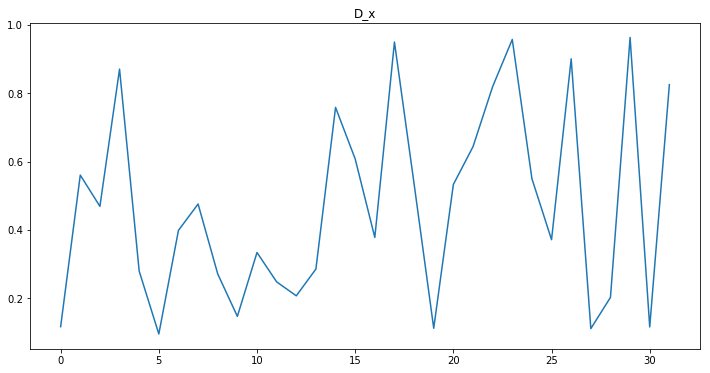

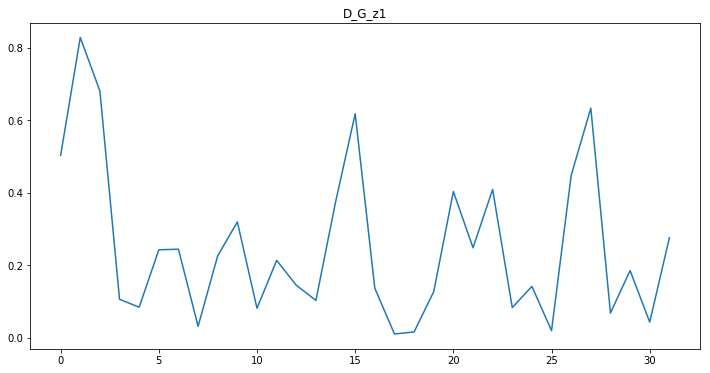

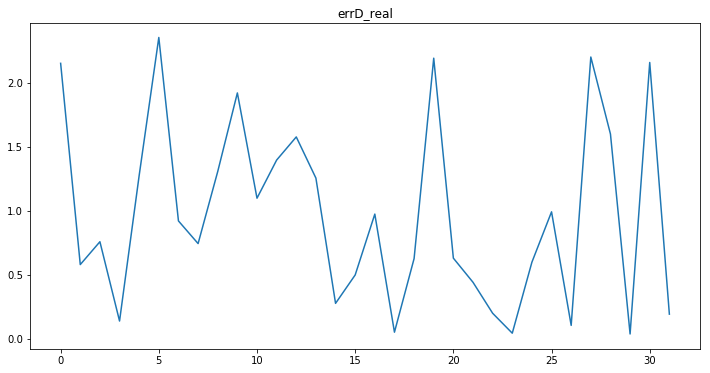

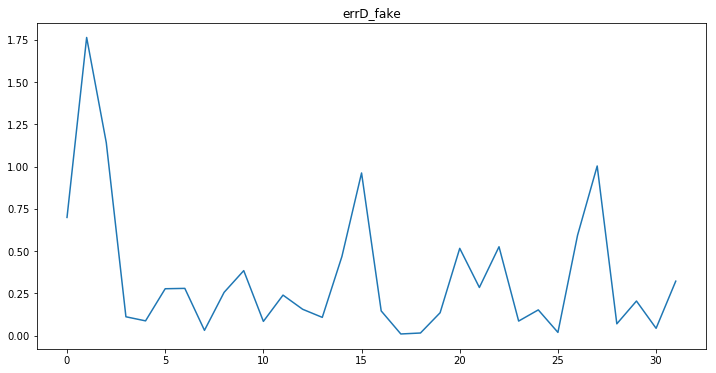

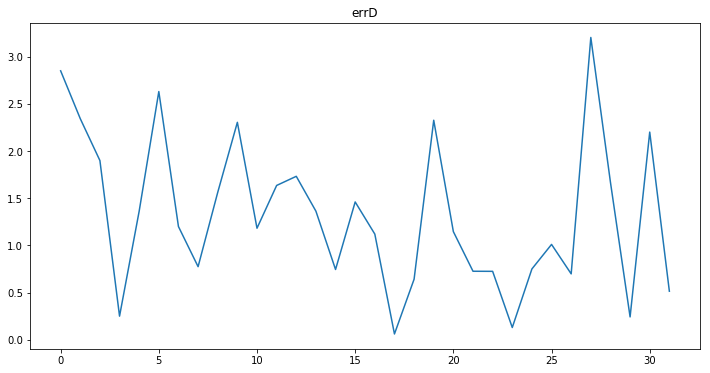

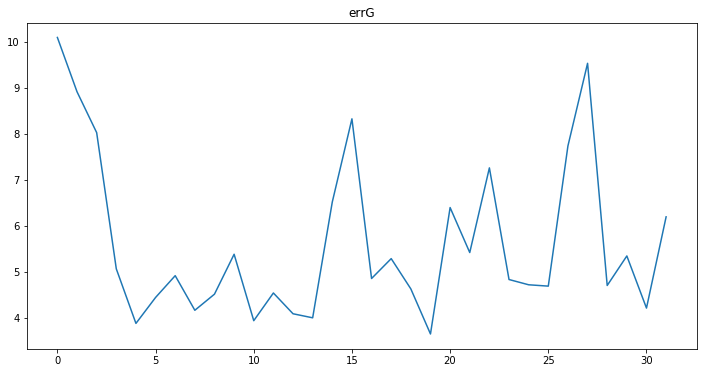

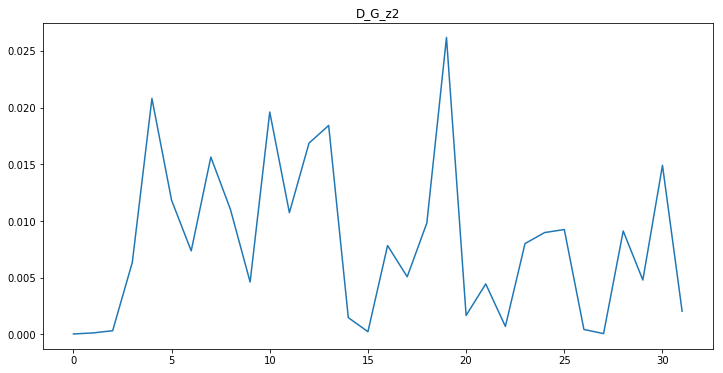

D_x = 0.9998847246170044
Forward Propagation of Generator
D_G_z1 = 0.7126314640045166
errD = errD_real + errD_fake = tensor(1.2471, grad_fn=<ThAddBackward>)
[1/25][0/32] Loss_D: 1.2471 Loss_G: 11.1731 D(x): 0.9999 D(G(z)): 0.7126 / 0.0000
D_x = 0.9997274279594421
Forward Propagation of Generator
D_G_z1 = 0.026456205174326897
errD = errD_real + errD_fake = tensor(0.0271, grad_fn=<ThAddBackward>)
[1/25][1/32] Loss_D: 0.0271 Loss_G: 5.8195 D(x): 0.9997 D(G(z)): 0.0265 / 0.0030
D_x = 0.996505618095398
Forward Propagation of Generator
D_G_z1 = 0.28905296325683594
errD = errD_real + errD_fake = tensor(0.3447, grad_fn=<ThAddBackward>)
[1/25][2/32] Loss_D: 0.3447 Loss_G: 7.1474 D(x): 0.9965 D(G(z)): 0.2891 / 0.0008
D_x = 0.9999183416366577
Forward Propagation of Generator
D_G_z1 = 0.15455210208892822
errD = errD_real + errD_fake = tensor(0.1680, grad_fn=<ThAddBackward>)
[1/25][3/32] Loss_D: 0.1680 Loss_G: 5.6225 D(x): 0.9999 D(G(z)): 0.1546 / 0.0036
D_x = 0.9998733997344971
Forward Propagation

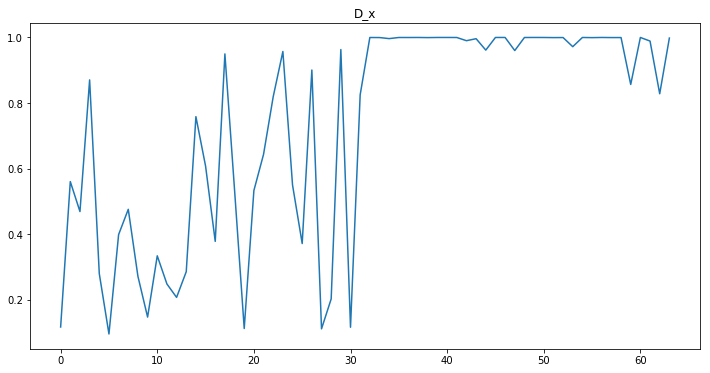

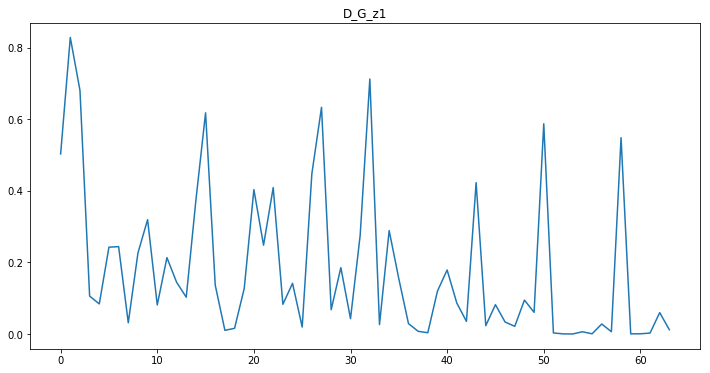

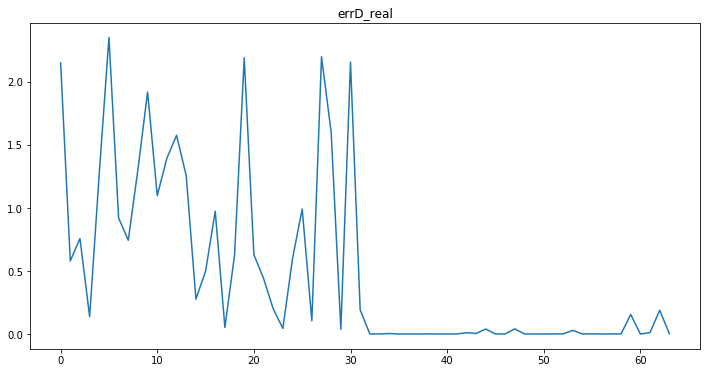

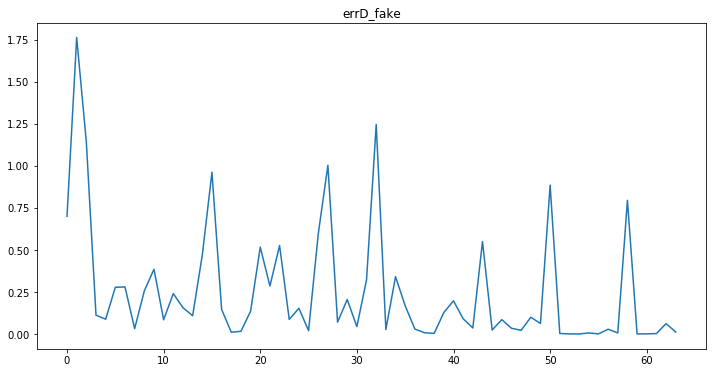

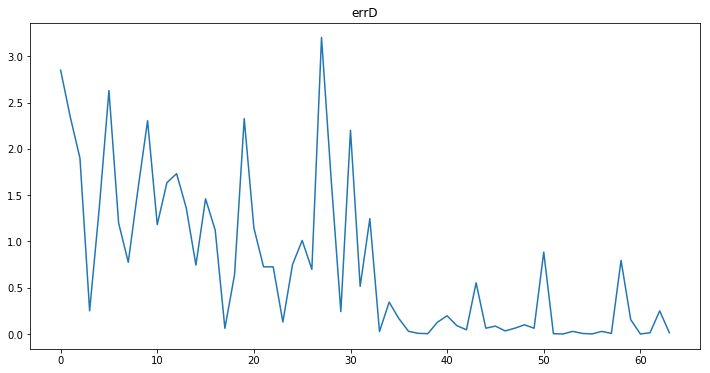

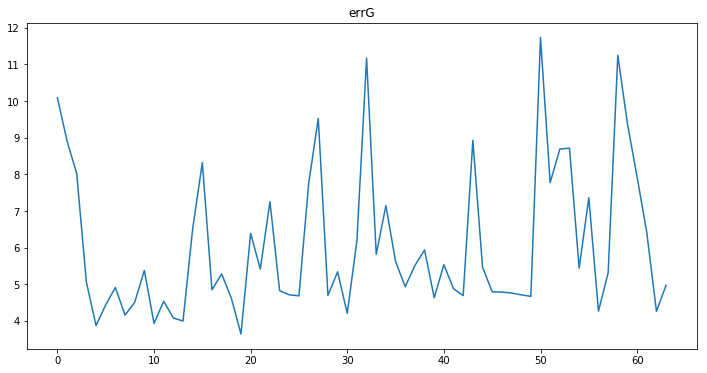

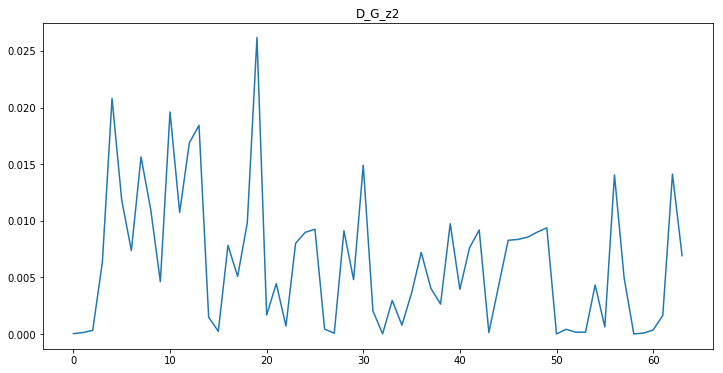

D_x = 0.9733293652534485
Forward Propagation of Generator
D_G_z1 = 0.06497716903686523
errD = errD_real + errD_fake = tensor(0.0942, grad_fn=<ThAddBackward>)
[2/25][0/32] Loss_D: 0.0942 Loss_G: 4.3649 D(x): 0.9733 D(G(z)): 0.0650 / 0.0127
D_x = 0.9996899366378784
Forward Propagation of Generator
D_G_z1 = 0.005435904487967491
errD = errD_real + errD_fake = tensor(0.0058, grad_fn=<ThAddBackward>)
[2/25][1/32] Loss_D: 0.0058 Loss_G: 5.6516 D(x): 0.9997 D(G(z)): 0.0054 / 0.0035
D_x = 0.9981318116188049
Forward Propagation of Generator
D_G_z1 = 0.0804779976606369
errD = errD_real + errD_fake = tensor(0.0858, grad_fn=<ThAddBackward>)
[2/25][2/32] Loss_D: 0.0858 Loss_G: 4.5253 D(x): 0.9981 D(G(z)): 0.0805 / 0.0108
D_x = 0.9820150136947632
Forward Propagation of Generator
D_G_z1 = 0.03830333054065704
errD = errD_real + errD_fake = tensor(0.0572, grad_fn=<ThAddBackward>)
[2/25][3/32] Loss_D: 0.0572 Loss_G: 4.5567 D(x): 0.9820 D(G(z)): 0.0383 / 0.0105
D_x = 0.9990315437316895
Forward Propagation

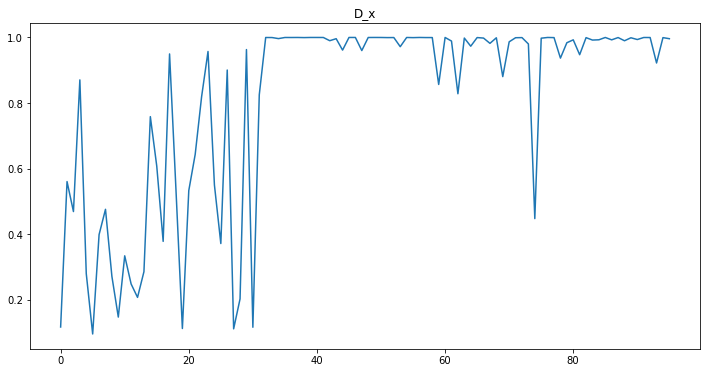

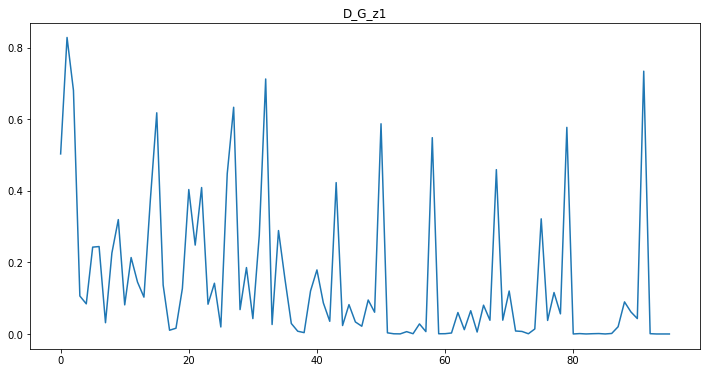

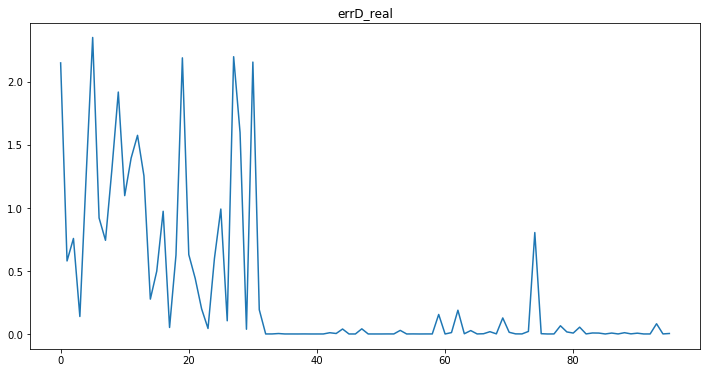

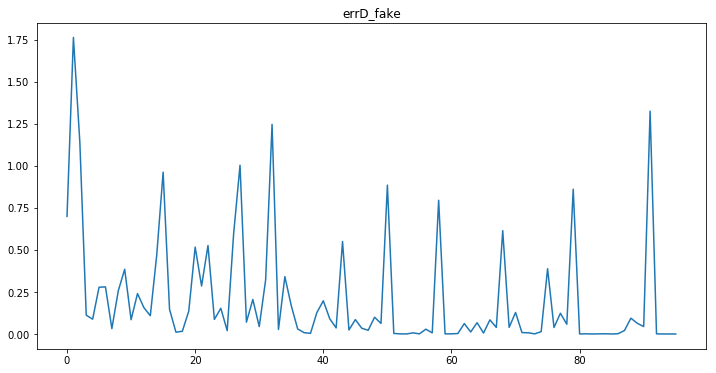

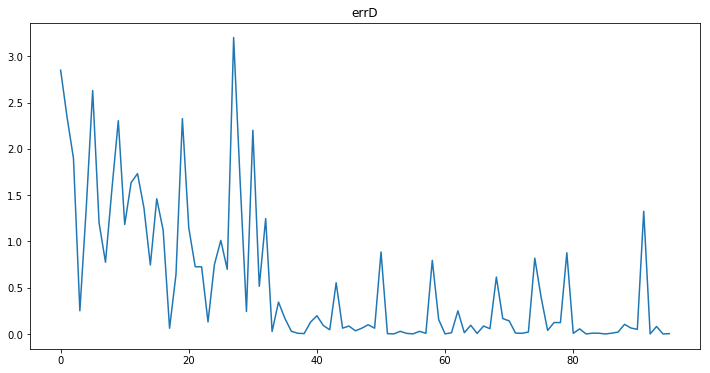

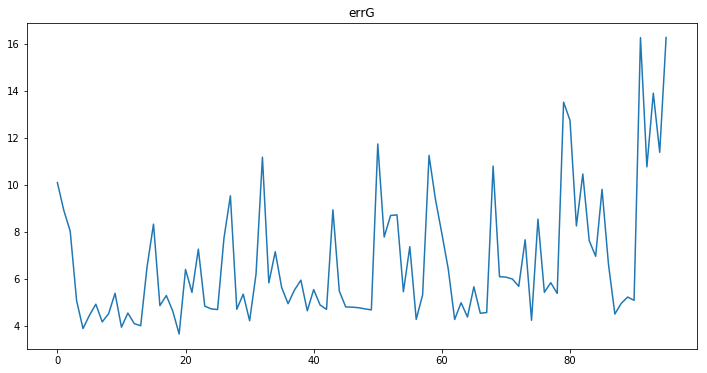

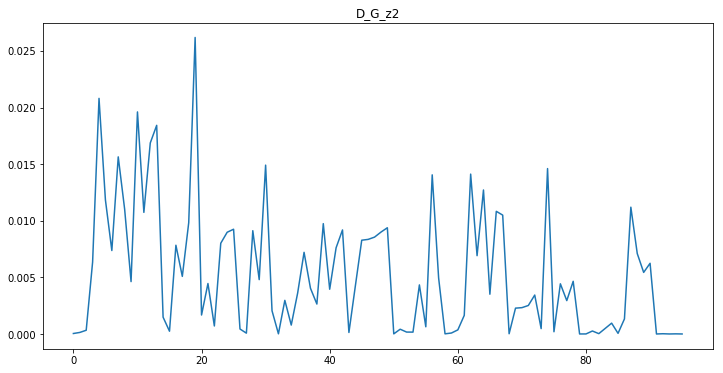

D_x = 0.9787878394126892
Forward Propagation of Generator
D_G_z1 = 0.004709094297140837
errD = errD_real + errD_fake = tensor(0.0262, grad_fn=<ThAddBackward>)
[3/25][0/32] Loss_D: 0.0262 Loss_G: 5.6491 D(x): 0.9788 D(G(z)): 0.0047 / 0.0035
D_x = 0.9633913636207581
Forward Propagation of Generator
D_G_z1 = 0.00029365799855440855
errD = errD_real + errD_fake = tensor(0.0376, grad_fn=<ThAddBackward>)
[3/25][1/32] Loss_D: 0.0376 Loss_G: 8.2300 D(x): 0.9634 D(G(z)): 0.0003 / 0.0003
D_x = 0.9777029156684875
Forward Propagation of Generator
D_G_z1 = 0.00018857113900594413
errD = errD_real + errD_fake = tensor(0.0227, grad_fn=<ThAddBackward>)
[3/25][2/32] Loss_D: 0.0227 Loss_G: 8.6142 D(x): 0.9777 D(G(z)): 0.0002 / 0.0002
D_x = 0.994102418422699
Forward Propagation of Generator
D_G_z1 = 0.000728188140783459
errD = errD_real + errD_fake = tensor(0.0066, grad_fn=<ThAddBackward>)
[3/25][3/32] Loss_D: 0.0066 Loss_G: 7.2520 D(x): 0.9941 D(G(z)): 0.0007 / 0.0007
D_x = 0.9768863320350647
Forward Prop

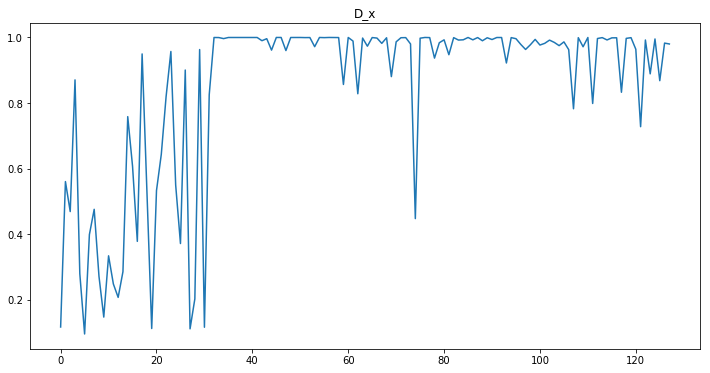

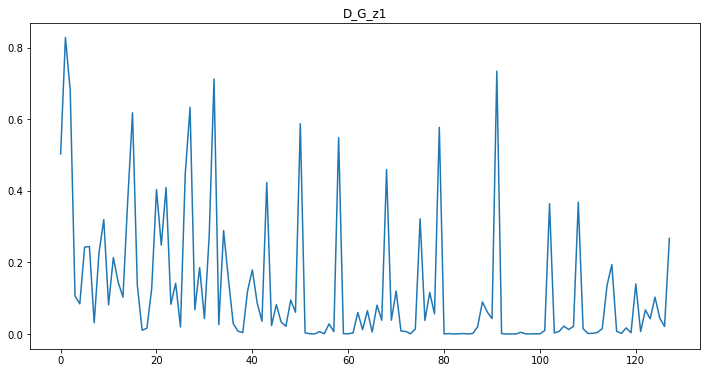

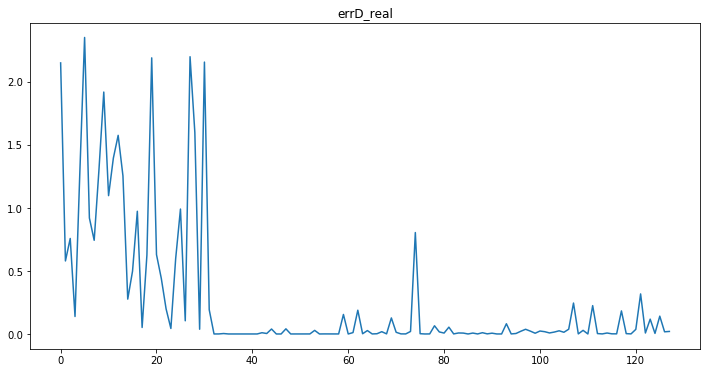

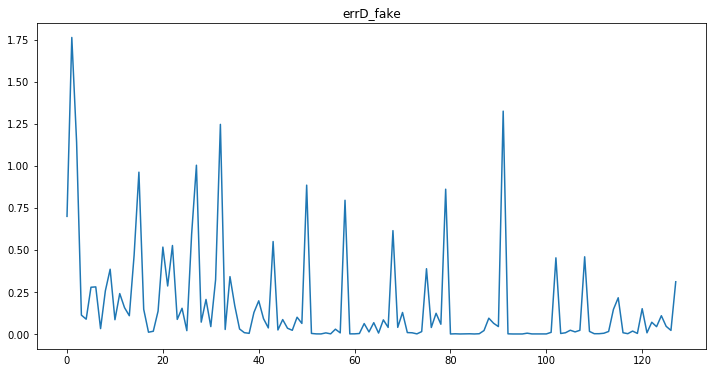

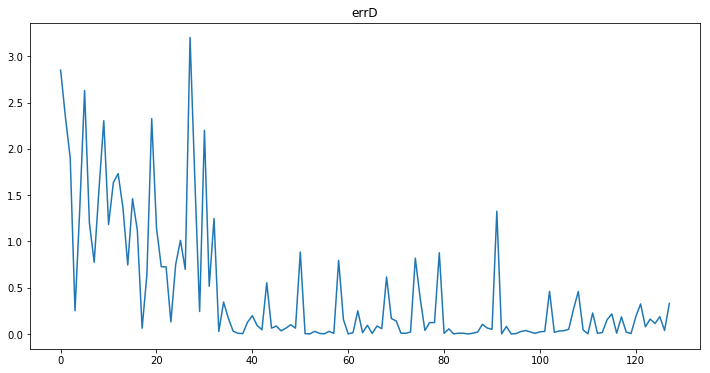

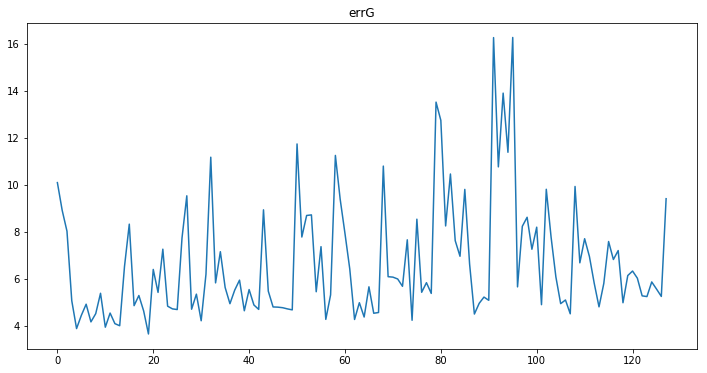

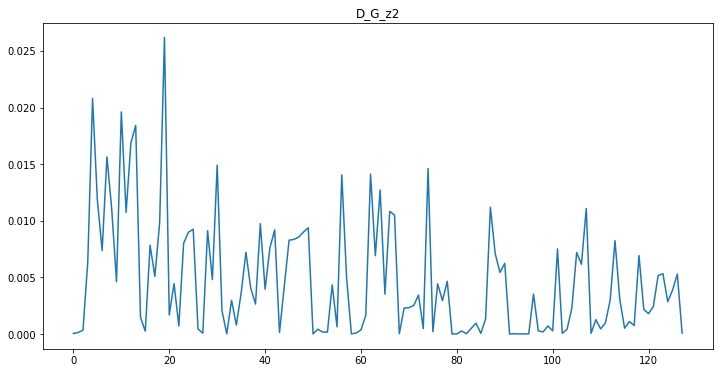

D_x = 0.9965781569480896
Forward Propagation of Generator
D_G_z1 = 0.005249017383903265
errD = errD_real + errD_fake = tensor(0.0087, grad_fn=<ThAddBackward>)
[4/25][0/32] Loss_D: 0.0087 Loss_G: 7.4885 D(x): 0.9966 D(G(z)): 0.0052 / 0.0006
D_x = 0.9987700581550598
Forward Propagation of Generator
D_G_z1 = 0.0003417849075049162
errD = errD_real + errD_fake = tensor(0.0016, grad_fn=<ThAddBackward>)
[4/25][1/32] Loss_D: 0.0016 Loss_G: 9.1679 D(x): 0.9988 D(G(z)): 0.0003 / 0.0001
D_x = 0.9970759153366089
Forward Propagation of Generator
D_G_z1 = 0.002213675994426012
errD = errD_real + errD_fake = tensor(0.0051, grad_fn=<ThAddBackward>)
[4/25][2/32] Loss_D: 0.0051 Loss_G: 6.7958 D(x): 0.9971 D(G(z)): 0.0022 / 0.0011
D_x = 0.9862993359565735
Forward Propagation of Generator
D_G_z1 = 0.0008814730099402368
errD = errD_real + errD_fake = tensor(0.0147, grad_fn=<ThAddBackward>)
[4/25][3/32] Loss_D: 0.0147 Loss_G: 7.3490 D(x): 0.9863 D(G(z)): 0.0009 / 0.0006
D_x = 0.9674256443977356
Forward Propa

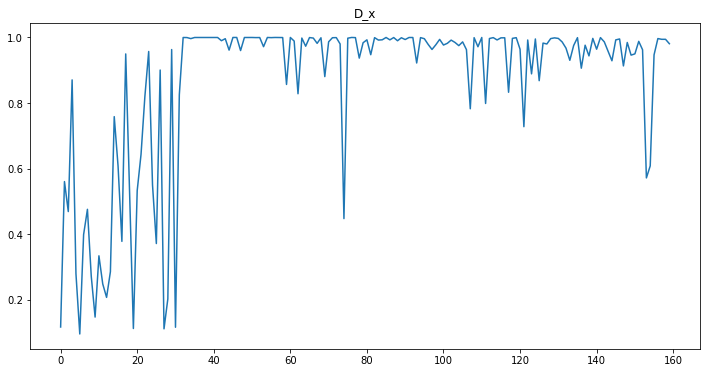

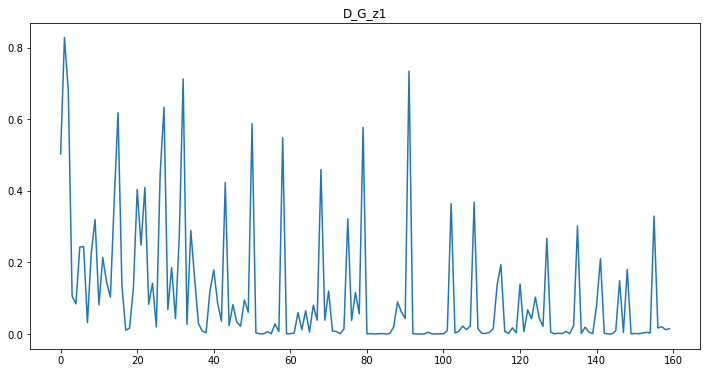

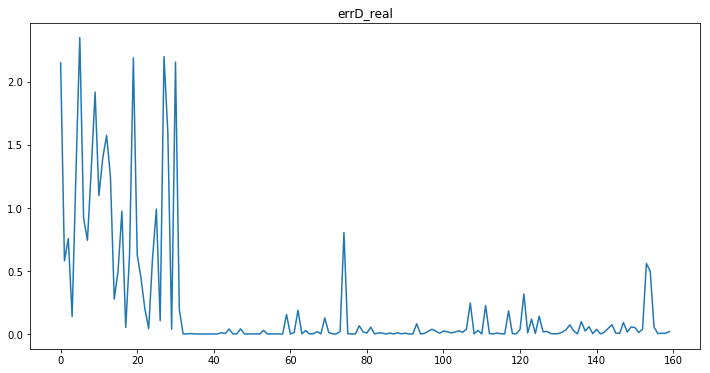

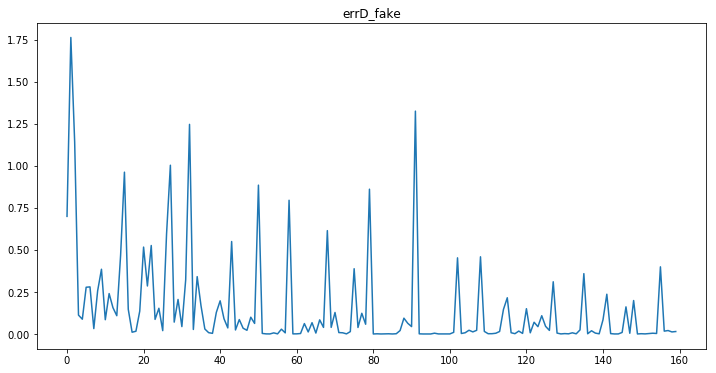

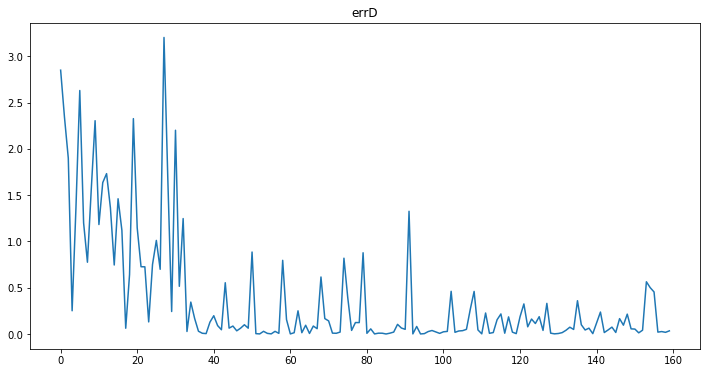

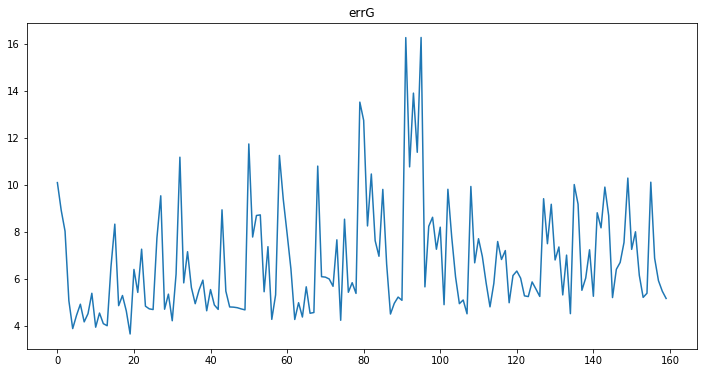

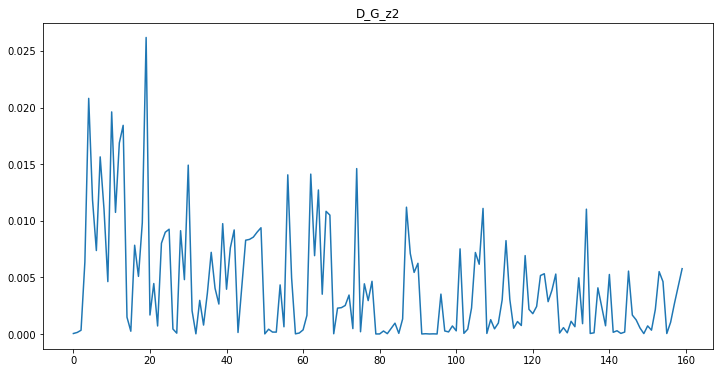

D_x = 0.9861228466033936
Forward Propagation of Generator
D_G_z1 = 0.01532788760960102
errD = errD_real + errD_fake = tensor(0.0294, grad_fn=<ThAddBackward>)
[5/25][0/32] Loss_D: 0.0294 Loss_G: 4.9982 D(x): 0.9861 D(G(z)): 0.0153 / 0.0067
D_x = 0.9774351119995117
Forward Propagation of Generator
D_G_z1 = 0.003924806602299213
errD = errD_real + errD_fake = tensor(0.0268, grad_fn=<ThAddBackward>)
[5/25][1/32] Loss_D: 0.0268 Loss_G: 5.9343 D(x): 0.9774 D(G(z)): 0.0039 / 0.0026
D_x = 0.9674310088157654
Forward Propagation of Generator
D_G_z1 = 0.06290683895349503
errD = errD_real + errD_fake = tensor(0.0981, grad_fn=<ThAddBackward>)
[5/25][2/32] Loss_D: 0.0981 Loss_G: 4.7296 D(x): 0.9674 D(G(z)): 0.0629 / 0.0088
D_x = 0.991649866104126
Forward Propagation of Generator
D_G_z1 = 0.0662134513258934
errD = errD_real + errD_fake = tensor(0.0769, grad_fn=<ThAddBackward>)
[5/25][3/32] Loss_D: 0.0769 Loss_G: 5.2017 D(x): 0.9916 D(G(z)): 0.0662 / 0.0055
D_x = 0.9743994474411011
Forward Propagation 

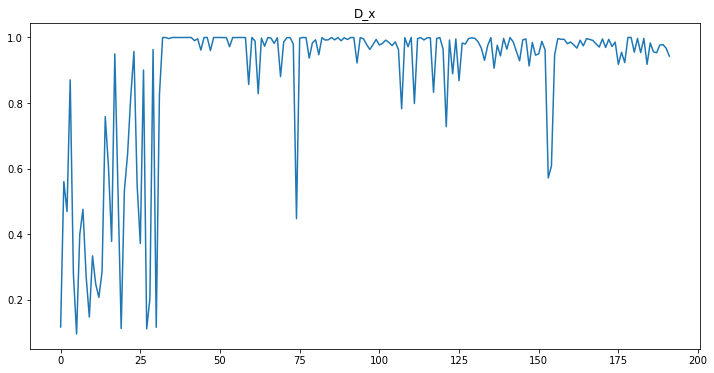

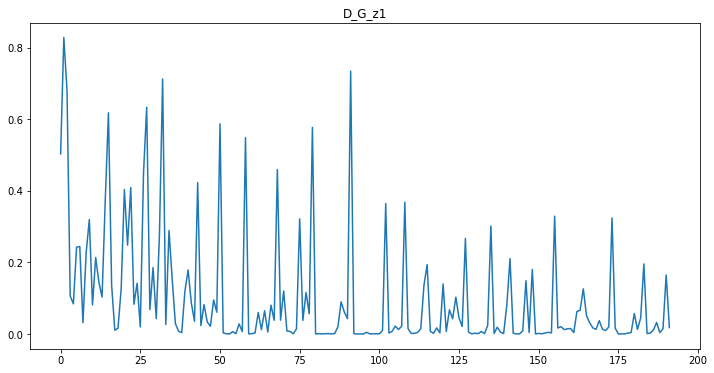

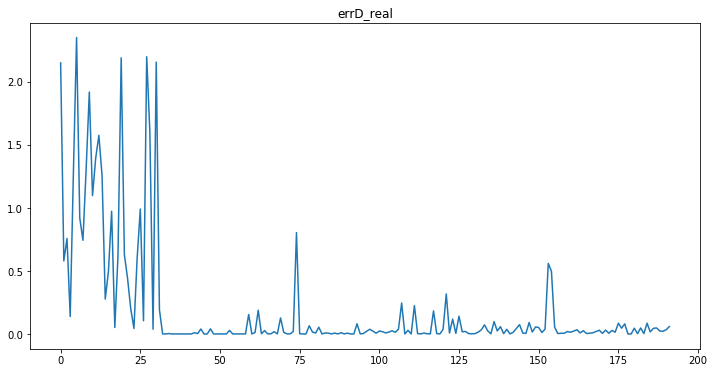

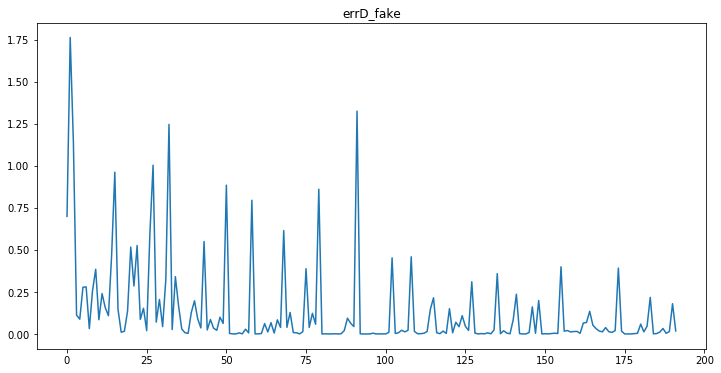

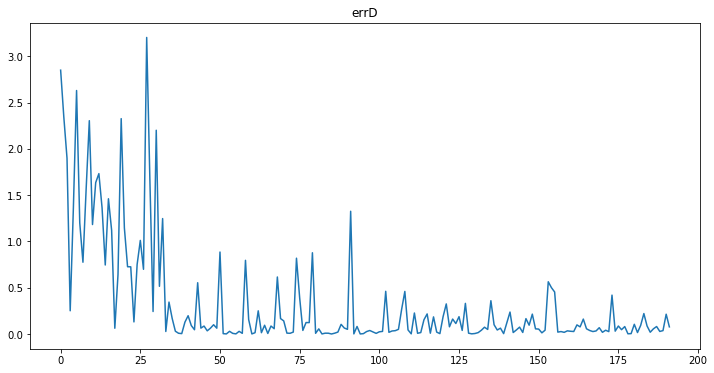

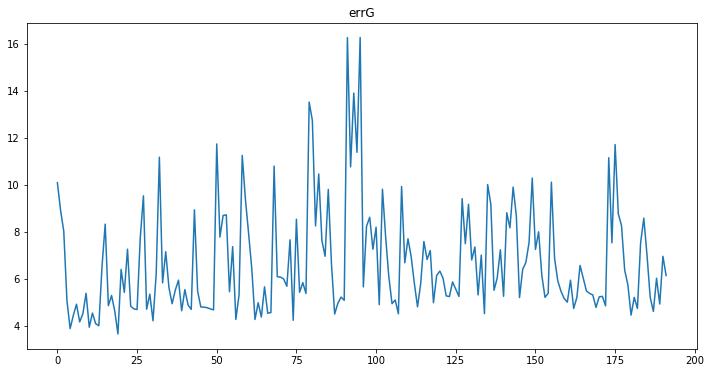

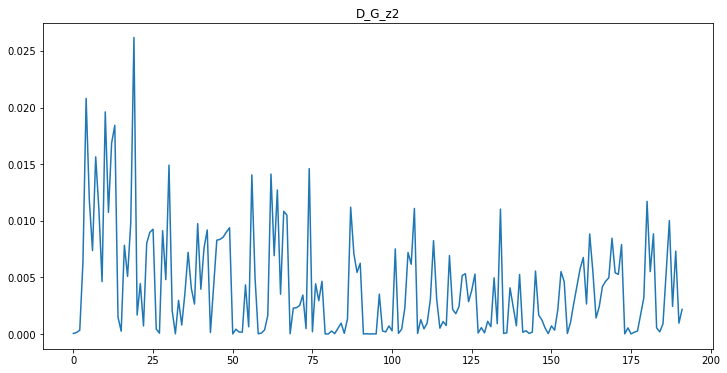

D_x = 0.8890270590782166
Forward Propagation of Generator
D_G_z1 = 0.0007257547113113105
errD = errD_real + errD_fake = tensor(0.1184, grad_fn=<ThAddBackward>)
[6/25][0/32] Loss_D: 0.1184 Loss_G: 8.0274 D(x): 0.8890 D(G(z)): 0.0007 / 0.0003
D_x = 0.9861235618591309
Forward Propagation of Generator
D_G_z1 = 0.003205917775630951
errD = errD_real + errD_fake = tensor(0.0172, grad_fn=<ThAddBackward>)
[6/25][1/32] Loss_D: 0.0172 Loss_G: 6.1944 D(x): 0.9861 D(G(z)): 0.0032 / 0.0020
D_x = 0.989691436290741
Forward Propagation of Generator
D_G_z1 = 0.01065383292734623
errD = errD_real + errD_fake = tensor(0.0211, grad_fn=<ThAddBackward>)
[6/25][2/32] Loss_D: 0.0211 Loss_G: 5.0733 D(x): 0.9897 D(G(z)): 0.0107 / 0.0063
D_x = 0.9834880232810974
Forward Propagation of Generator
D_G_z1 = 0.3383079171180725
errD = errD_real + errD_fake = tensor(0.4296, grad_fn=<ThAddBackward>)
[6/25][3/32] Loss_D: 0.4296 Loss_G: 11.0803 D(x): 0.9835 D(G(z)): 0.3383 / 0.0000
D_x = 0.980553388595581
Forward Propagatio

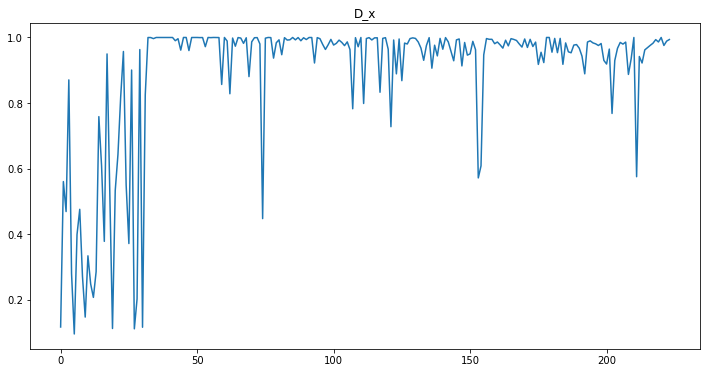

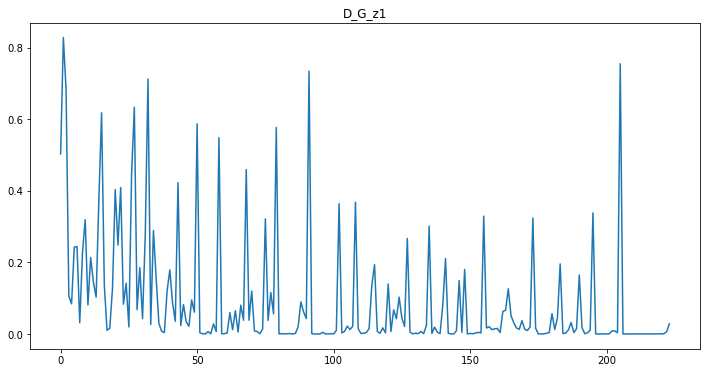

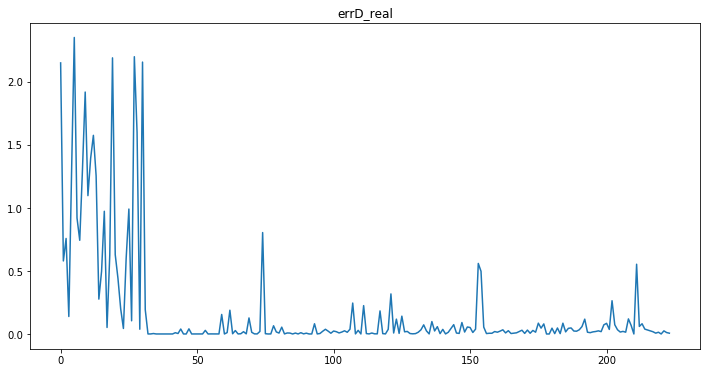

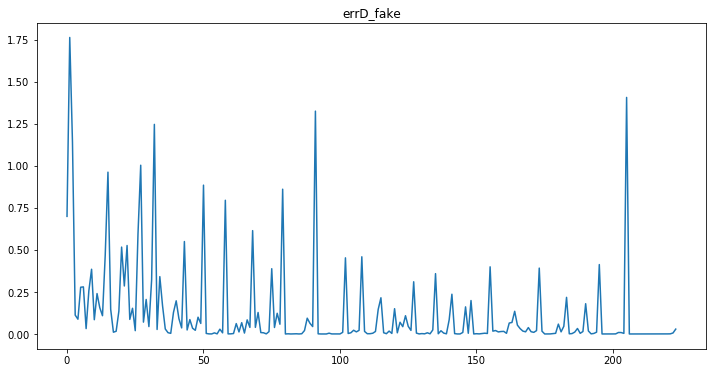

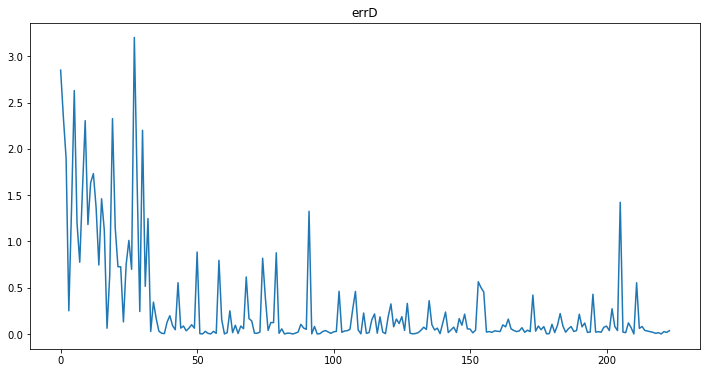

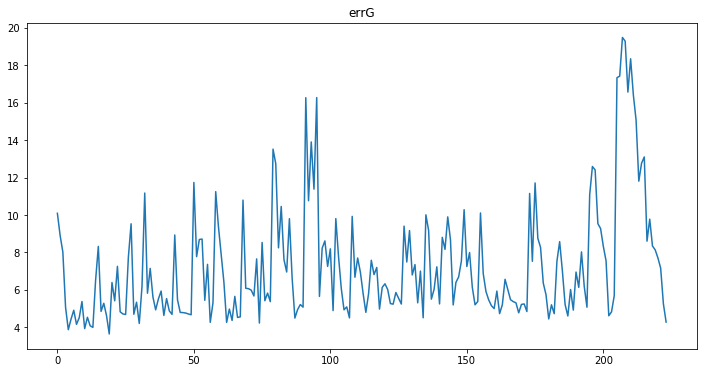

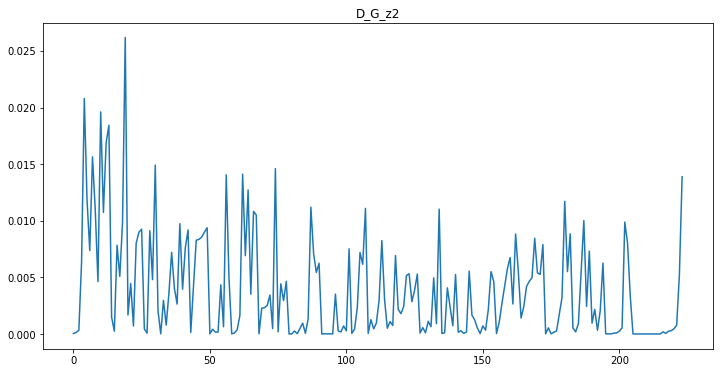

D_x = 0.9951604008674622
Forward Propagation of Generator
D_G_z1 = 0.05943600833415985
errD = errD_real + errD_fake = tensor(0.0661, grad_fn=<ThAddBackward>)
[7/25][0/32] Loss_D: 0.0661 Loss_G: 4.5550 D(x): 0.9952 D(G(z)): 0.0594 / 0.0105
D_x = 0.9949302077293396
Forward Propagation of Generator
D_G_z1 = 0.10658220946788788
errD = errD_real + errD_fake = tensor(0.1178, grad_fn=<ThAddBackward>)
[7/25][1/32] Loss_D: 0.1178 Loss_G: 5.4344 D(x): 0.9949 D(G(z)): 0.1066 / 0.0044
D_x = 0.9973032474517822
Forward Propagation of Generator
D_G_z1 = 0.0072672246024012566
errD = errD_real + errD_fake = tensor(0.0100, grad_fn=<ThAddBackward>)
[7/25][2/32] Loss_D: 0.0100 Loss_G: 6.2316 D(x): 0.9973 D(G(z)): 0.0073 / 0.0020
D_x = 0.9903358221054077
Forward Propagation of Generator
D_G_z1 = 0.01241688895970583
errD = errD_real + errD_fake = tensor(0.0222, grad_fn=<ThAddBackward>)
[7/25][3/32] Loss_D: 0.0222 Loss_G: 5.3028 D(x): 0.9903 D(G(z)): 0.0124 / 0.0050
D_x = 0.9982516169548035
Forward Propagati

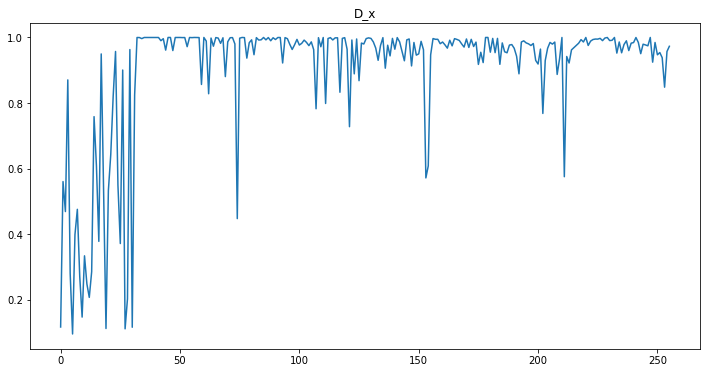

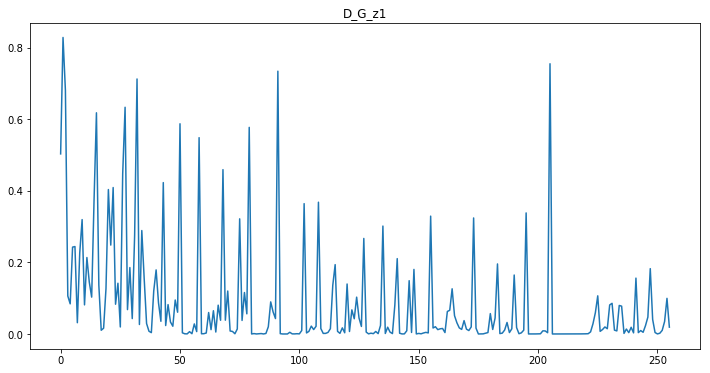

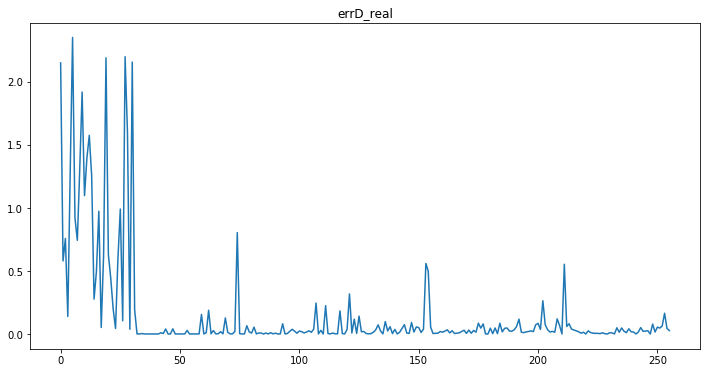

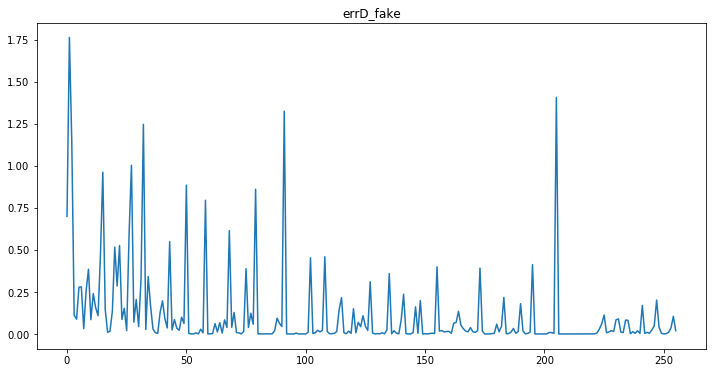

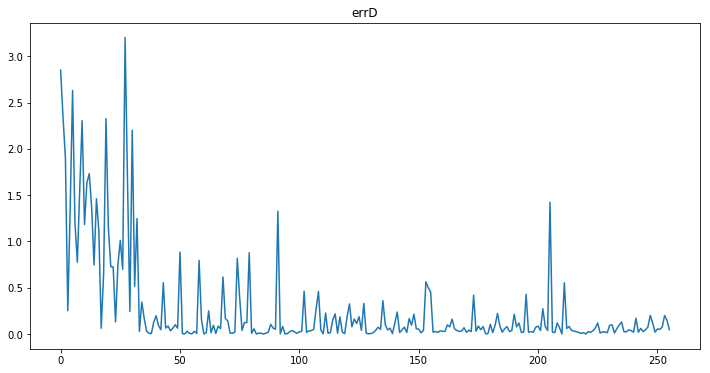

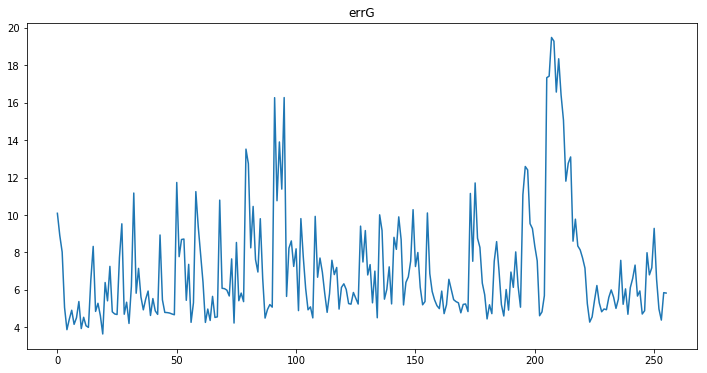

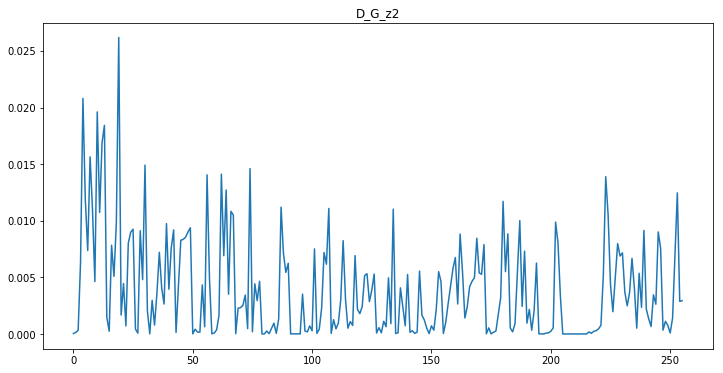

D_x = 0.9735079407691956
Forward Propagation of Generator
D_G_z1 = 0.013366310857236385
errD = errD_real + errD_fake = tensor(0.0403, grad_fn=<ThAddBackward>)
[8/25][0/32] Loss_D: 0.0403 Loss_G: 5.5114 D(x): 0.9735 D(G(z)): 0.0134 / 0.0040
D_x = 0.9741740822792053
Forward Propagation of Generator
D_G_z1 = 0.0030622724443674088
errD = errD_real + errD_fake = tensor(0.0292, grad_fn=<ThAddBackward>)
[8/25][1/32] Loss_D: 0.0292 Loss_G: 6.3775 D(x): 0.9742 D(G(z)): 0.0031 / 0.0017
D_x = 0.9849563241004944
Forward Propagation of Generator
D_G_z1 = 0.05055205523967743
errD = errD_real + errD_fake = tensor(0.0670, grad_fn=<ThAddBackward>)
[8/25][2/32] Loss_D: 0.0670 Loss_G: 5.0618 D(x): 0.9850 D(G(z)): 0.0506 / 0.0063
D_x = 0.9857999086380005
Forward Propagation of Generator
D_G_z1 = 0.04711709916591644
errD = errD_real + errD_fake = tensor(0.0626, grad_fn=<ThAddBackward>)
[8/25][3/32] Loss_D: 0.0626 Loss_G: 5.4162 D(x): 0.9858 D(G(z)): 0.0471 / 0.0044
D_x = 0.9682623744010925
Forward Propagat

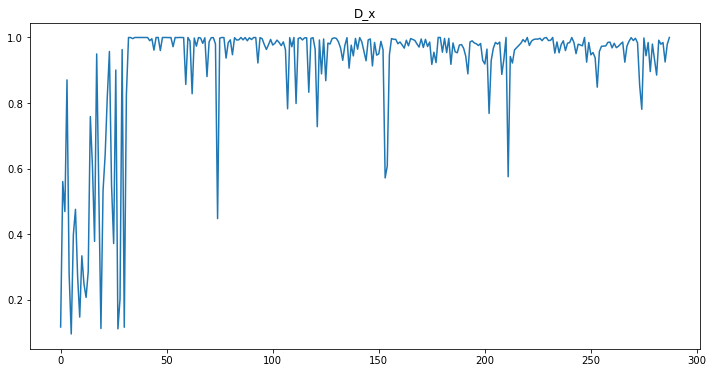

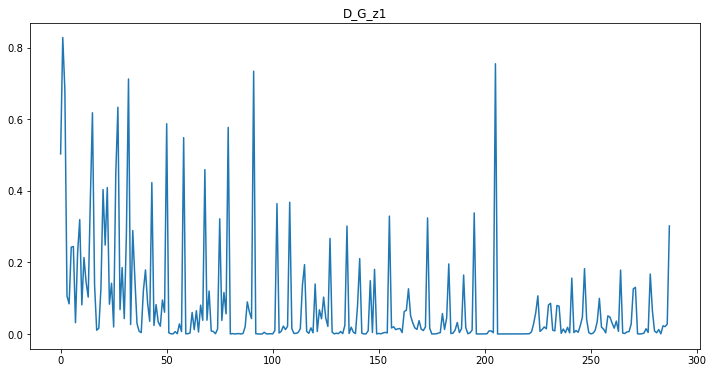

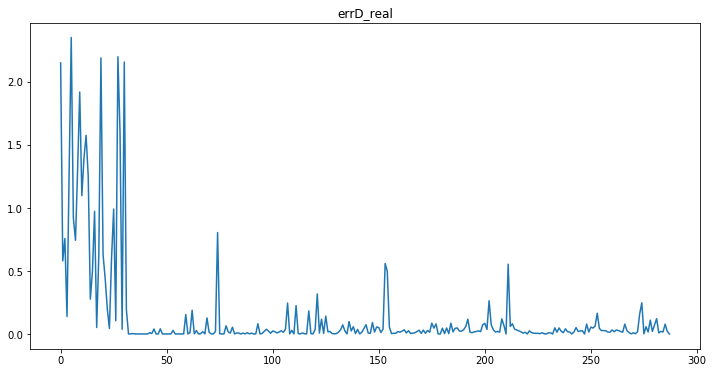

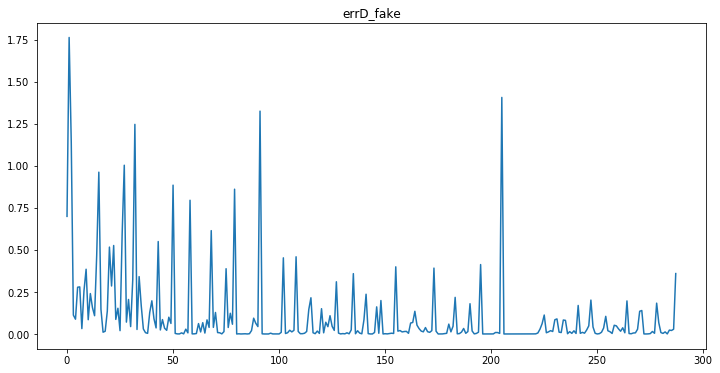

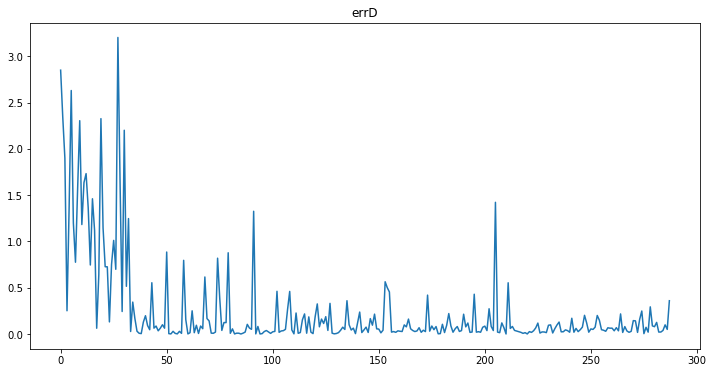

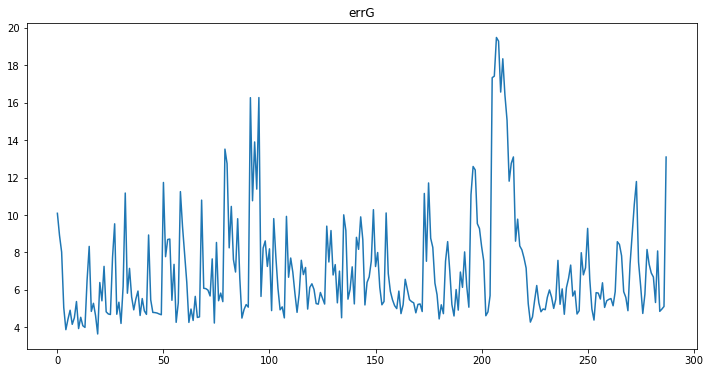

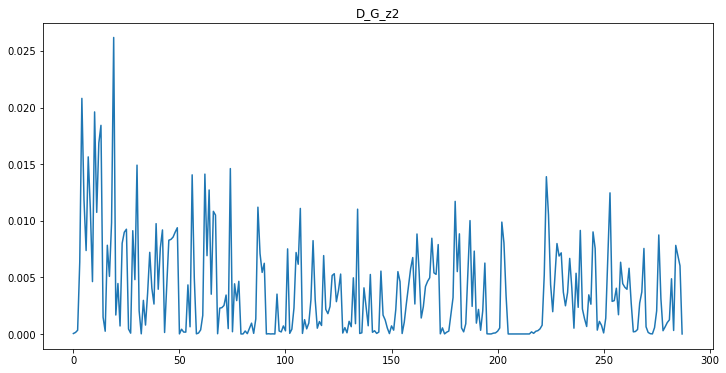

D_x = 0.9751731157302856
Forward Propagation of Generator
D_G_z1 = 0.00012440115096978843
errD = errD_real + errD_fake = tensor(0.0253, grad_fn=<ThAddBackward>)
[9/25][0/32] Loss_D: 0.0253 Loss_G: 13.2073 D(x): 0.9752 D(G(z)): 0.0001 / 0.0000
D_x = 0.9965372085571289
Forward Propagation of Generator
D_G_z1 = 7.475221536878962e-06
errD = errD_real + errD_fake = tensor(0.0035, grad_fn=<ThAddBackward>)
[9/25][1/32] Loss_D: 0.0035 Loss_G: 13.7144 D(x): 0.9965 D(G(z)): 0.0000 / 0.0000
D_x = 0.9683922529220581
Forward Propagation of Generator
D_G_z1 = 5.505876288225409e-07
errD = errD_real + errD_fake = tensor(0.0321, grad_fn=<ThAddBackward>)
[9/25][2/32] Loss_D: 0.0321 Loss_G: 15.2816 D(x): 0.9684 D(G(z)): 0.0000 / 0.0000
D_x = 0.981941819190979
Forward Propagation of Generator
D_G_z1 = 1.0805897545651533e-05
errD = errD_real + errD_fake = tensor(0.0182, grad_fn=<ThAddBackward>)
[9/25][3/32] Loss_D: 0.0182 Loss_G: 11.8585 D(x): 0.9819 D(G(z)): 0.0000 / 0.0000
D_x = 0.9491541385650635
Forwar

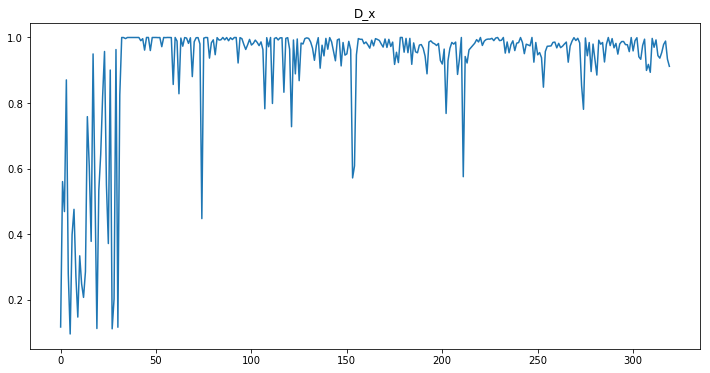

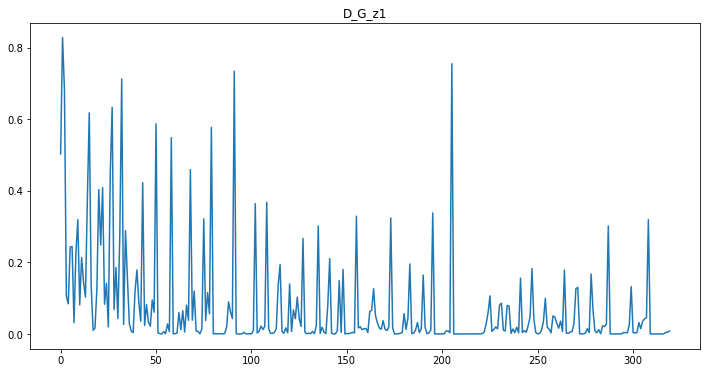

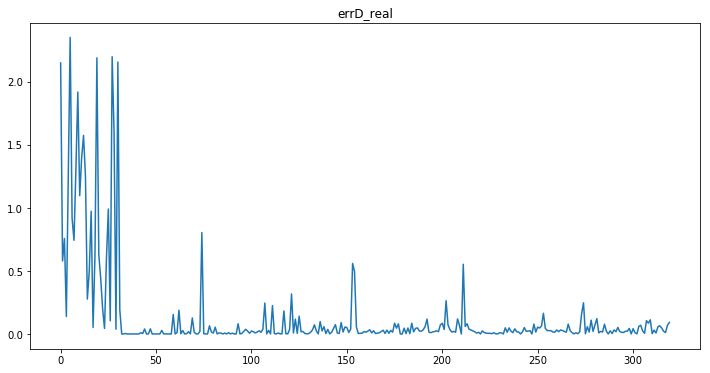

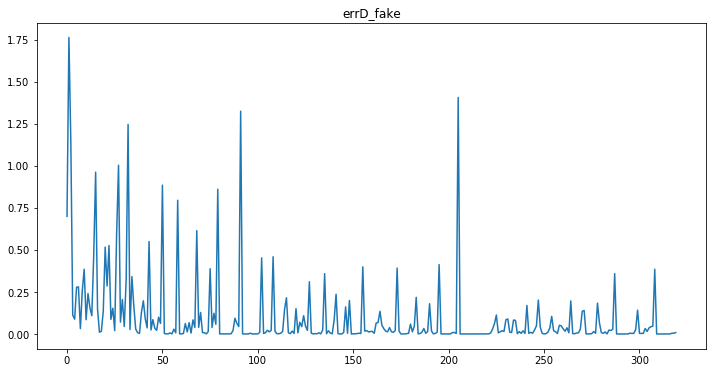

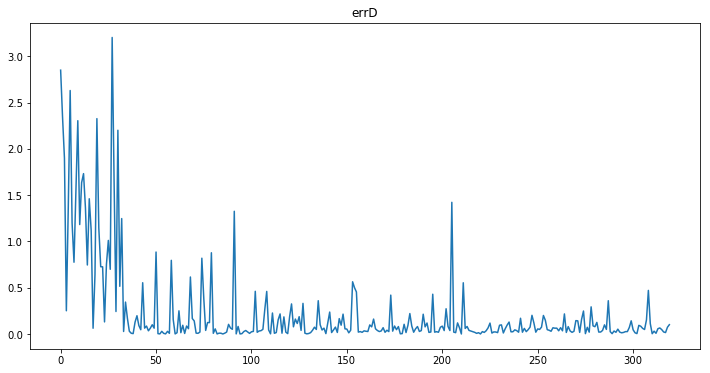

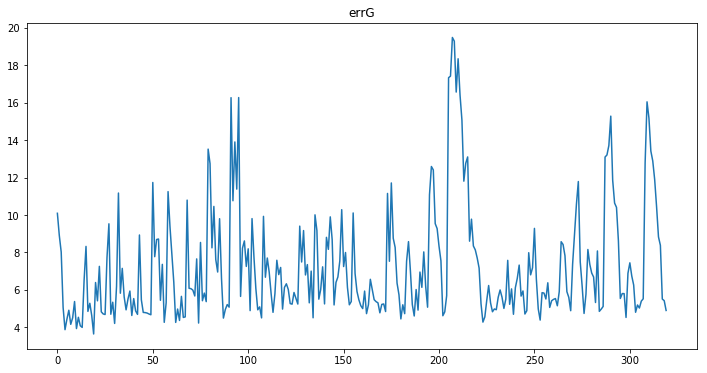

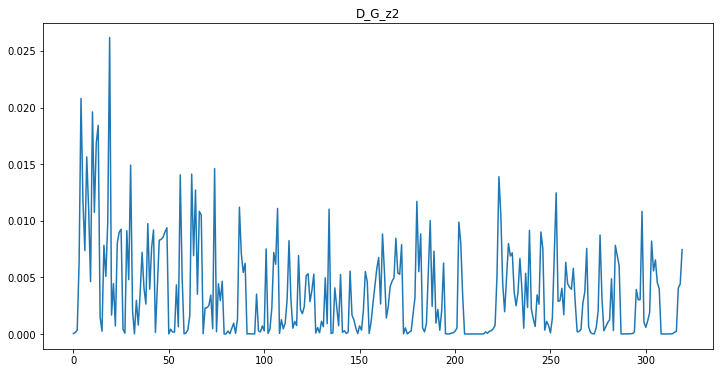

D_x = 0.9973165392875671
Forward Propagation of Generator
D_G_z1 = 0.016320480033755302
errD = errD_real + errD_fake = tensor(0.0191, grad_fn=<ThAddBackward>)
[10/25][0/32] Loss_D: 0.0191 Loss_G: 4.6762 D(x): 0.9973 D(G(z)): 0.0163 / 0.0093
D_x = 0.9828135967254639
Forward Propagation of Generator
D_G_z1 = 0.03054777905344963
errD = errD_real + errD_fake = tensor(0.0484, grad_fn=<ThAddBackward>)
[10/25][1/32] Loss_D: 0.0484 Loss_G: 4.6958 D(x): 0.9828 D(G(z)): 0.0305 / 0.0091
D_x = 0.9730970859527588
Forward Propagation of Generator
D_G_z1 = 0.1582743525505066
errD = errD_real + errD_fake = tensor(0.1996, grad_fn=<ThAddBackward>)
[10/25][2/32] Loss_D: 0.1996 Loss_G: 7.3698 D(x): 0.9731 D(G(z)): 0.1583 / 0.0006
D_x = 0.9957643747329712
Forward Propagation of Generator
D_G_z1 = 0.010733157396316528
errD = errD_real + errD_fake = tensor(0.0150, grad_fn=<ThAddBackward>)
[10/25][3/32] Loss_D: 0.0150 Loss_G: 6.9619 D(x): 0.9958 D(G(z)): 0.0107 / 0.0009
D_x = 0.9755609631538391
Forward Propag

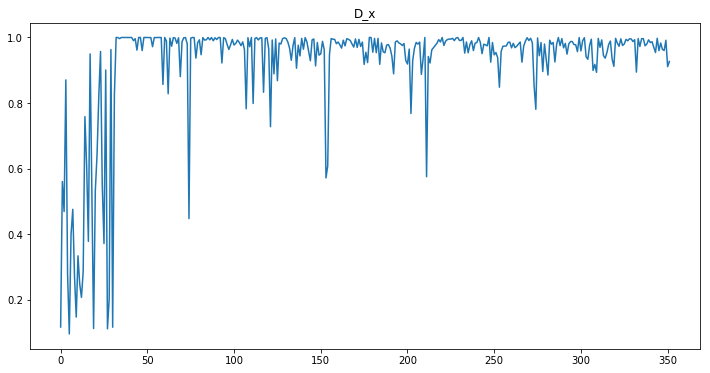

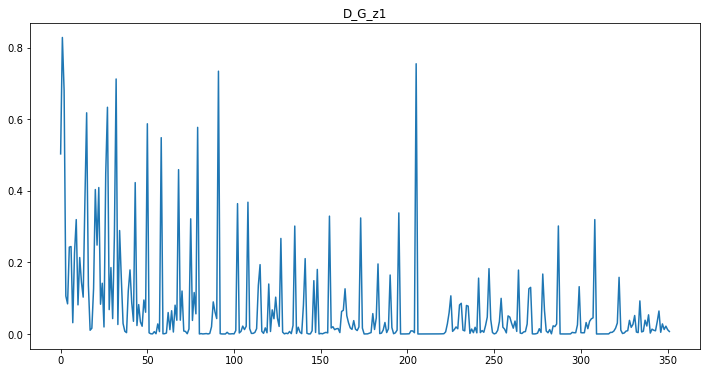

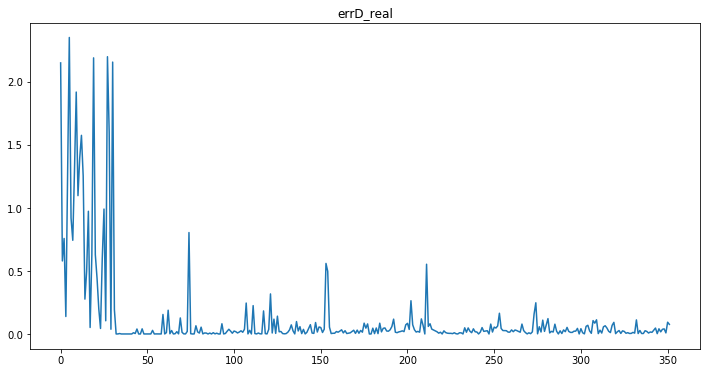

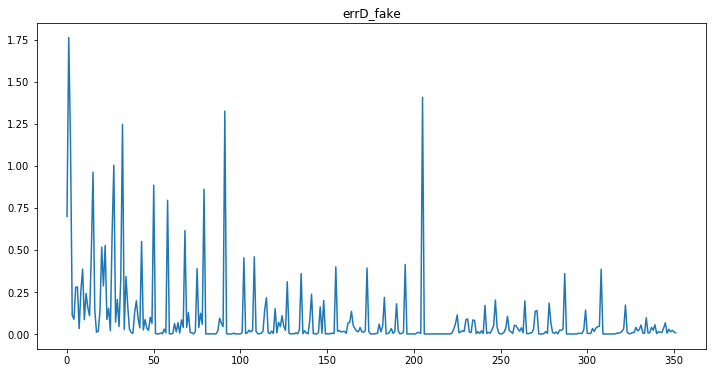

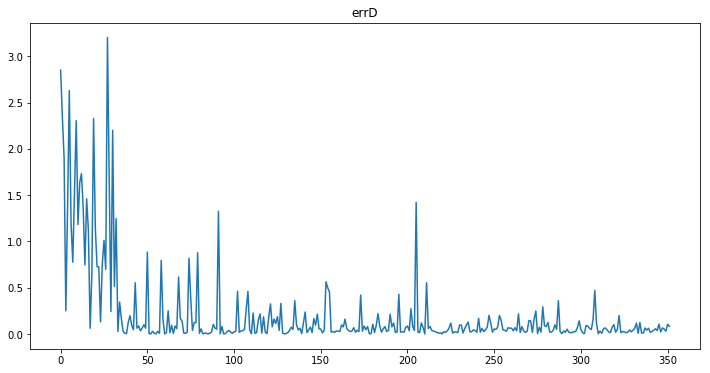

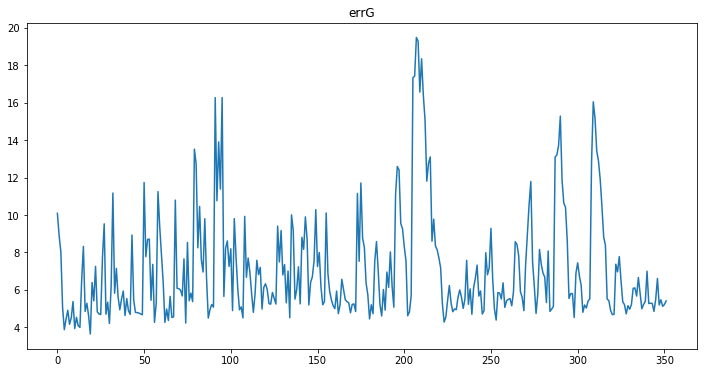

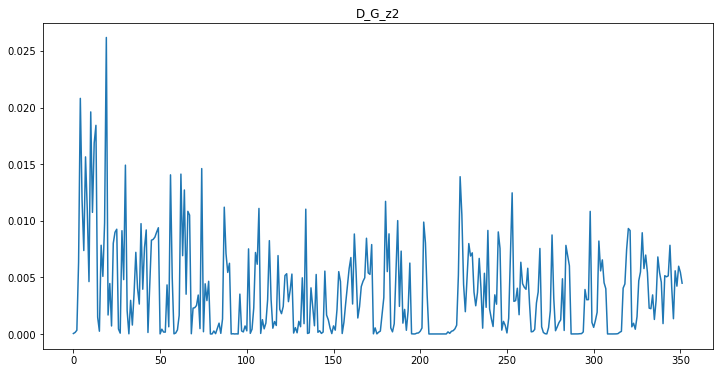

D_x = 0.9797163009643555
Forward Propagation of Generator
D_G_z1 = 0.15641850233078003
errD = errD_real + errD_fake = tensor(0.1906, grad_fn=<ThAddBackward>)
[11/25][0/32] Loss_D: 0.1906 Loss_G: 7.7422 D(x): 0.9797 D(G(z)): 0.1564 / 0.0004
D_x = 0.9916722178459167
Forward Propagation of Generator
D_G_z1 = 0.0008777408511377871
errD = errD_real + errD_fake = tensor(0.0092, grad_fn=<ThAddBackward>)
[11/25][1/32] Loss_D: 0.0092 Loss_G: 9.2057 D(x): 0.9917 D(G(z)): 0.0009 / 0.0001
D_x = 0.9953590035438538
Forward Propagation of Generator
D_G_z1 = 0.0014186212792992592
errD = errD_real + errD_fake = tensor(0.0061, grad_fn=<ThAddBackward>)
[11/25][2/32] Loss_D: 0.0061 Loss_G: 7.6897 D(x): 0.9954 D(G(z)): 0.0014 / 0.0005
D_x = 0.977206826210022
Forward Propagation of Generator
D_G_z1 = 0.0004003887006547302
errD = errD_real + errD_fake = tensor(0.0235, grad_fn=<ThAddBackward>)
[11/25][3/32] Loss_D: 0.0235 Loss_G: 8.3540 D(x): 0.9772 D(G(z)): 0.0004 / 0.0002
D_x = 0.962303102016449
Forward Pro

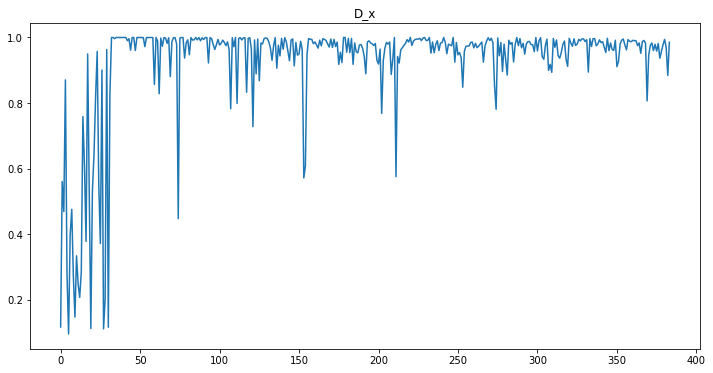

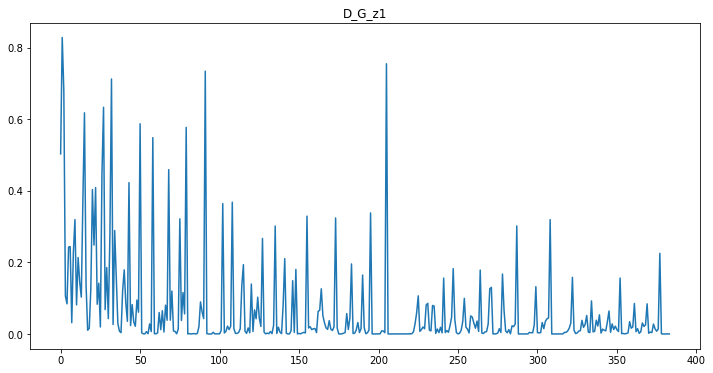

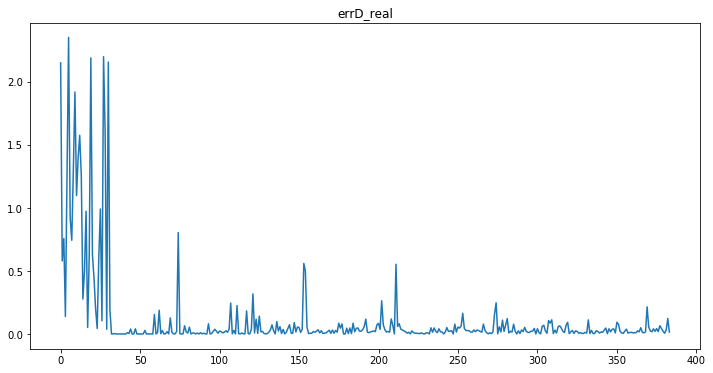

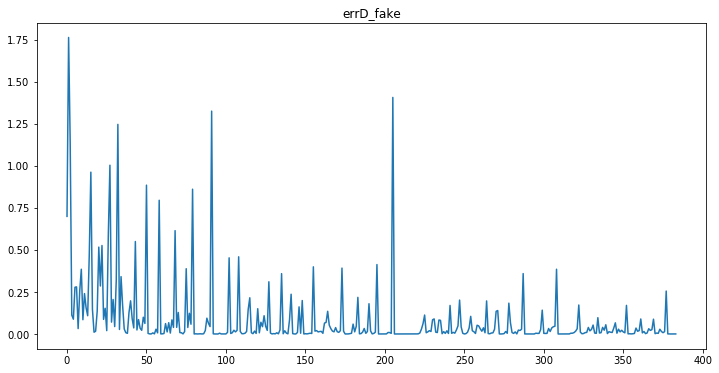

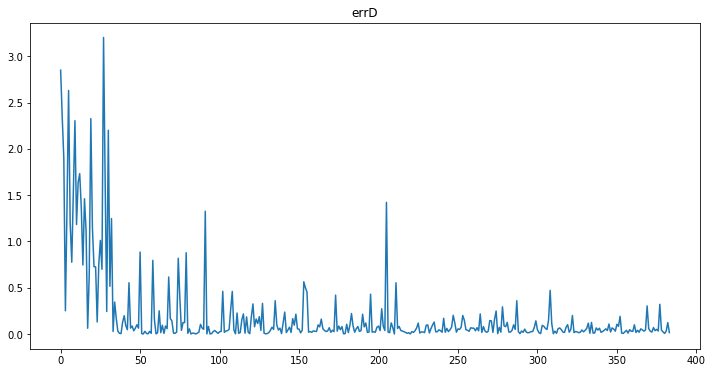

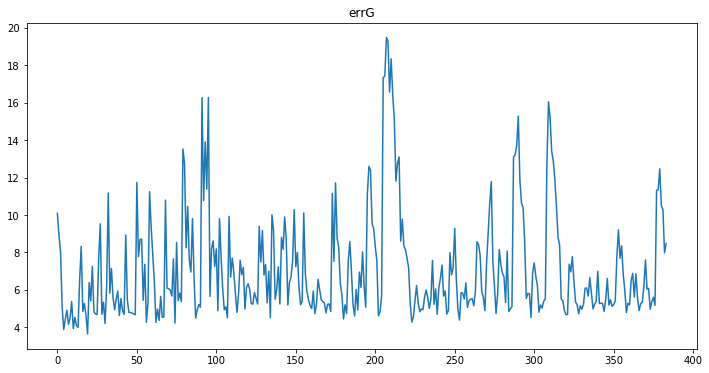

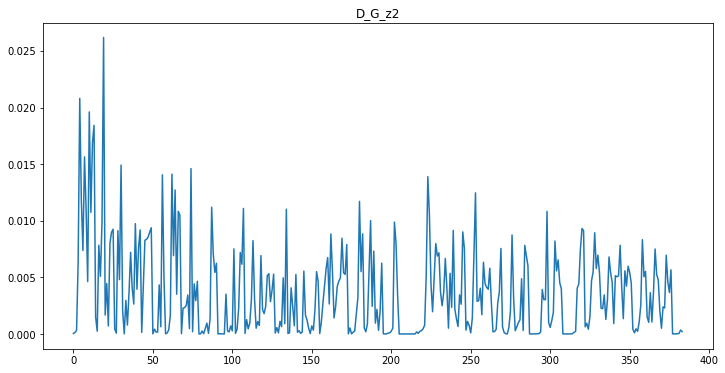

D_x = 0.985405683517456
Forward Propagation of Generator
D_G_z1 = 0.001632821629755199
errD = errD_real + errD_fake = tensor(0.0163, grad_fn=<ThAddBackward>)
[12/25][0/32] Loss_D: 0.0163 Loss_G: 6.4377 D(x): 0.9854 D(G(z)): 0.0016 / 0.0016
D_x = 0.9892686009407043
Forward Propagation of Generator
D_G_z1 = 0.0028933340217918158
errD = errD_real + errD_fake = tensor(0.0137, grad_fn=<ThAddBackward>)
[12/25][1/32] Loss_D: 0.0137 Loss_G: 5.9411 D(x): 0.9893 D(G(z)): 0.0029 / 0.0026
D_x = 0.9998489618301392
Forward Propagation of Generator
D_G_z1 = 0.013198597356677055
errD = errD_real + errD_fake = tensor(0.0134, grad_fn=<ThAddBackward>)
[12/25][2/32] Loss_D: 0.0134 Loss_G: 4.8811 D(x): 0.9998 D(G(z)): 0.0132 / 0.0076
D_x = 0.9875562787055969
Forward Propagation of Generator
D_G_z1 = 0.05268728733062744
errD = errD_real + errD_fake = tensor(0.0666, grad_fn=<ThAddBackward>)
[12/25][3/32] Loss_D: 0.0666 Loss_G: 5.2808 D(x): 0.9876 D(G(z)): 0.0527 / 0.0051
D_x = 0.9948221445083618
Forward Prop

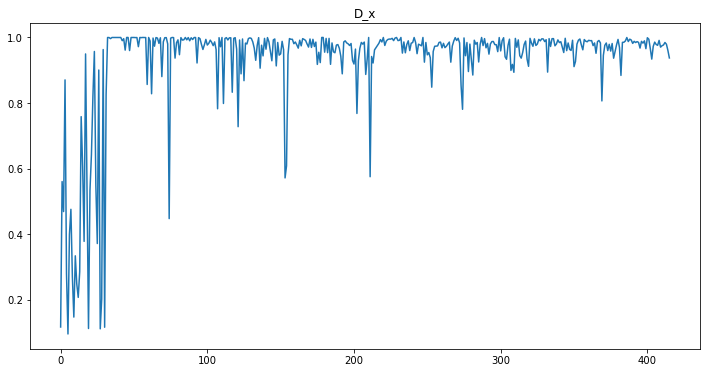

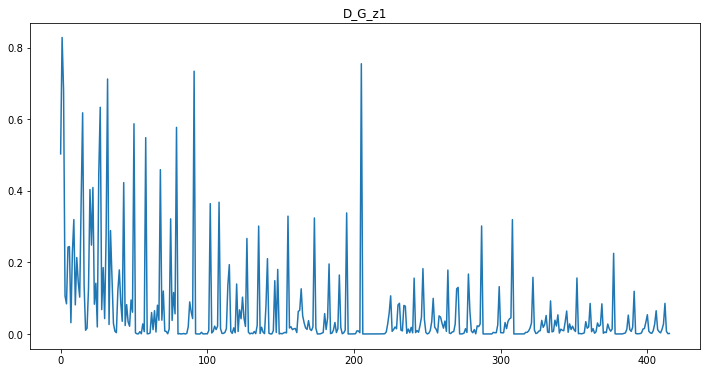

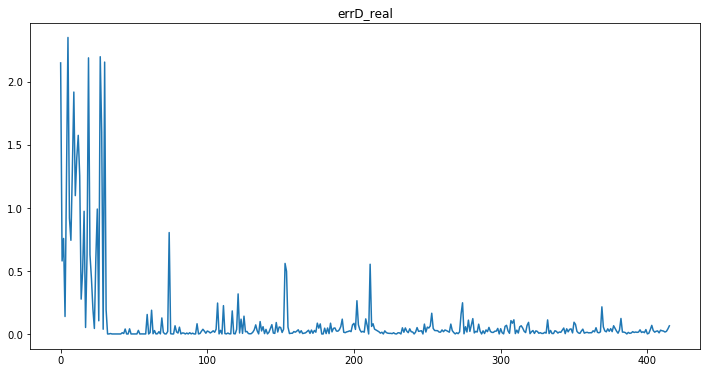

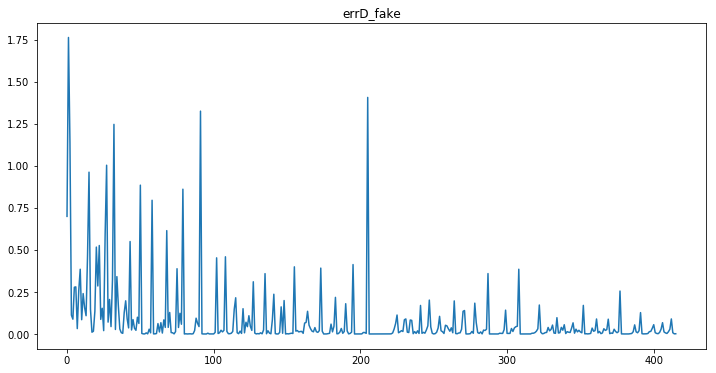

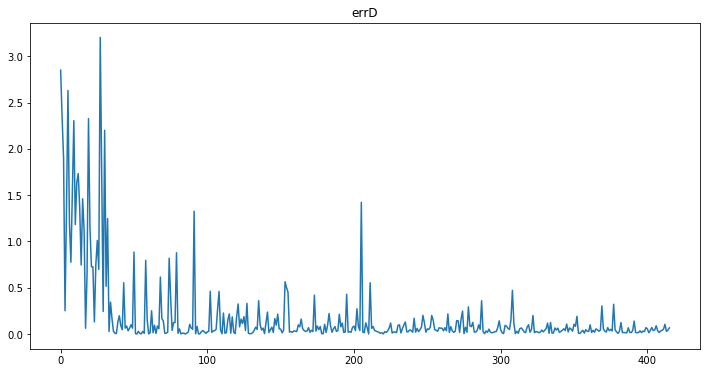

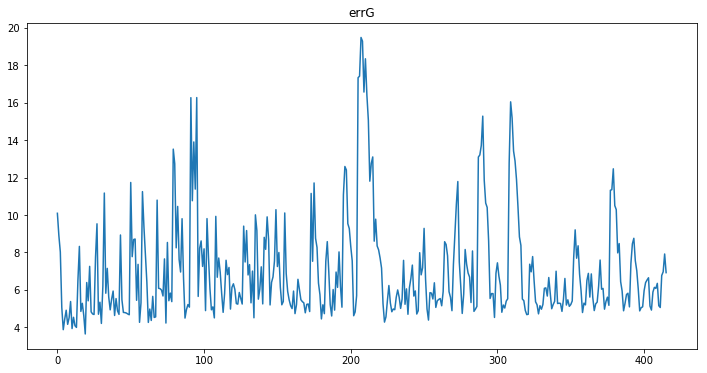

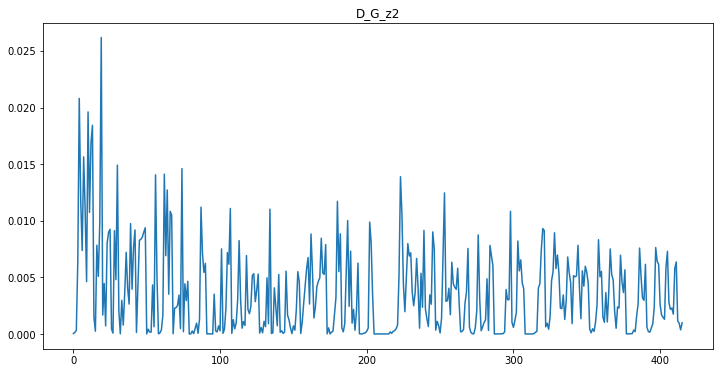

D_x = 0.9907103180885315
Forward Propagation of Generator
D_G_z1 = 0.0006573607097379863
errD = errD_real + errD_fake = tensor(0.0100, grad_fn=<ThAddBackward>)
[13/25][0/32] Loss_D: 0.0100 Loss_G: 7.5046 D(x): 0.9907 D(G(z)): 0.0007 / 0.0006
D_x = 0.9928481578826904
Forward Propagation of Generator
D_G_z1 = 0.002443017205223441
errD = errD_real + errD_fake = tensor(0.0096, grad_fn=<ThAddBackward>)
[13/25][1/32] Loss_D: 0.0096 Loss_G: 6.2049 D(x): 0.9928 D(G(z)): 0.0024 / 0.0020
D_x = 0.9903268218040466
Forward Propagation of Generator
D_G_z1 = 0.011327245272696018
errD = errD_real + errD_fake = tensor(0.0211, grad_fn=<ThAddBackward>)
[13/25][2/32] Loss_D: 0.0211 Loss_G: 5.0407 D(x): 0.9903 D(G(z)): 0.0113 / 0.0065
D_x = 0.9867841005325317
Forward Propagation of Generator
D_G_z1 = 0.028118552640080452
errD = errD_real + errD_fake = tensor(0.0418, grad_fn=<ThAddBackward>)
[13/25][3/32] Loss_D: 0.0418 Loss_G: 5.0131 D(x): 0.9868 D(G(z)): 0.0281 / 0.0067
D_x = 0.9921795129776001
Forward Pr

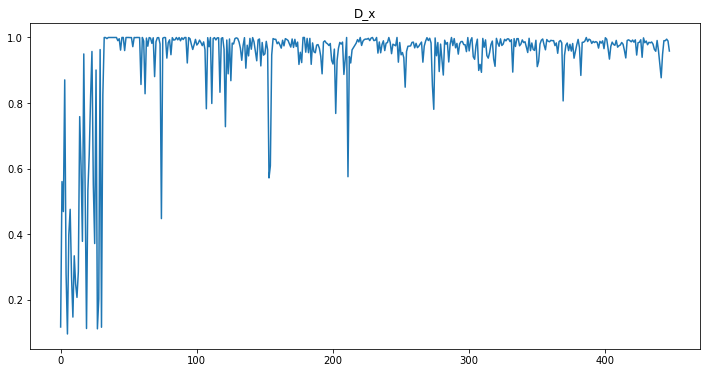

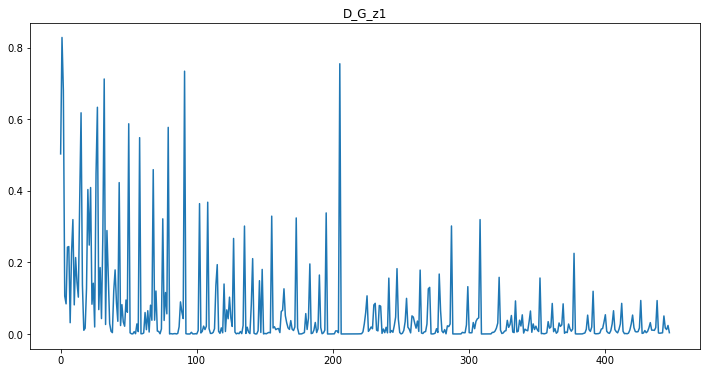

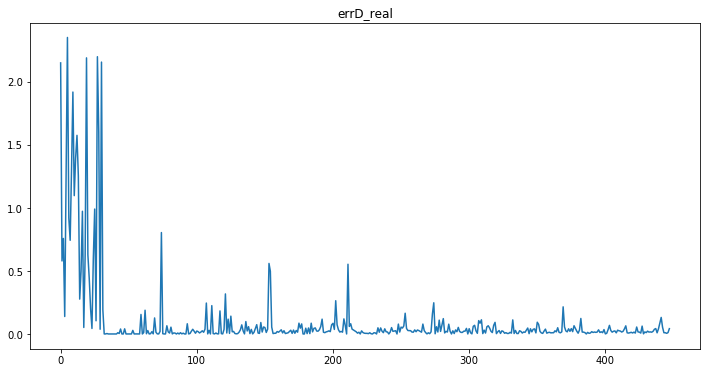

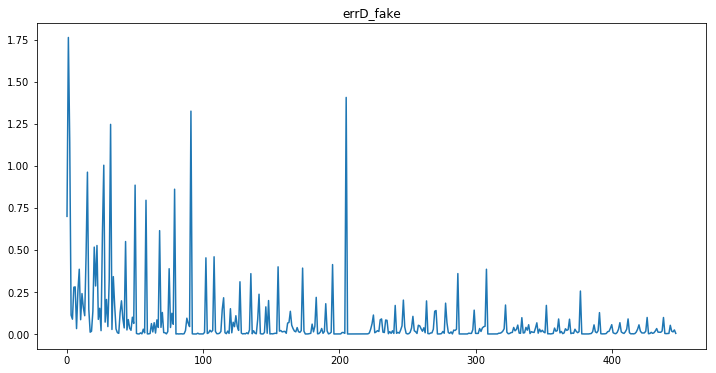

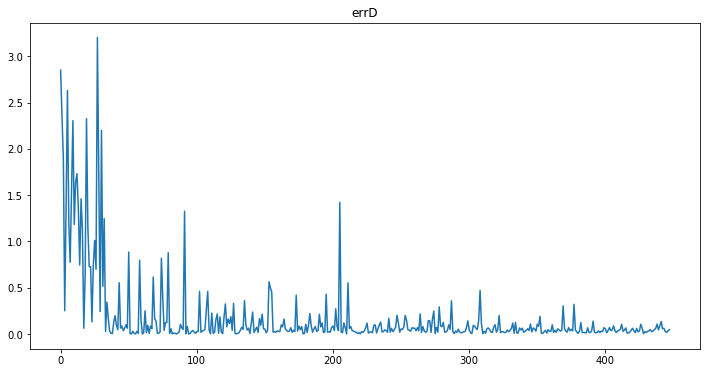

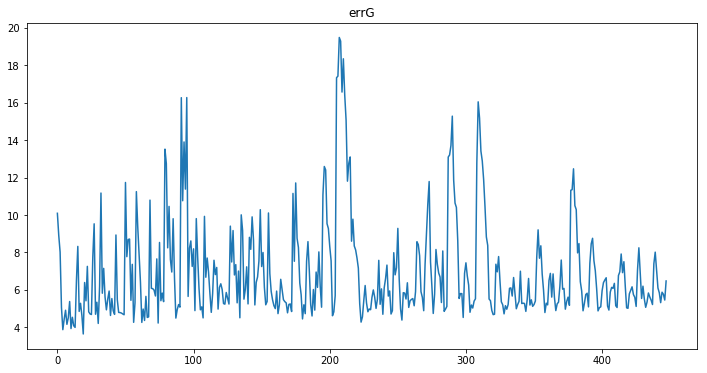

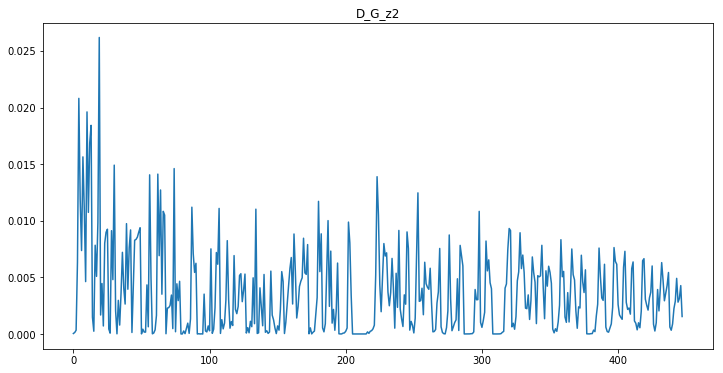

D_x = 0.9895276427268982
Forward Propagation of Generator
D_G_z1 = 0.000847429211717099
errD = errD_real + errD_fake = tensor(0.0114, grad_fn=<ThAddBackward>)
[14/25][0/32] Loss_D: 0.0114 Loss_G: 7.4911 D(x): 0.9895 D(G(z)): 0.0008 / 0.0006
D_x = 0.9916329383850098
Forward Propagation of Generator
D_G_z1 = 0.034681402146816254
errD = errD_real + errD_fake = tensor(0.0437, grad_fn=<ThAddBackward>)
[14/25][1/32] Loss_D: 0.0437 Loss_G: 5.1774 D(x): 0.9916 D(G(z)): 0.0347 / 0.0056
D_x = 0.9926018118858337
Forward Propagation of Generator
D_G_z1 = 0.013197840191423893
errD = errD_real + errD_fake = tensor(0.0207, grad_fn=<ThAddBackward>)
[14/25][2/32] Loss_D: 0.0207 Loss_G: 5.7026 D(x): 0.9926 D(G(z)): 0.0132 / 0.0033
D_x = 0.9871960878372192
Forward Propagation of Generator
D_G_z1 = 0.015251471661031246
errD = errD_real + errD_fake = tensor(0.0283, grad_fn=<ThAddBackward>)
[14/25][3/32] Loss_D: 0.0283 Loss_G: 5.5350 D(x): 0.9872 D(G(z)): 0.0153 / 0.0039
D_x = 0.9924430251121521
Forward Pro

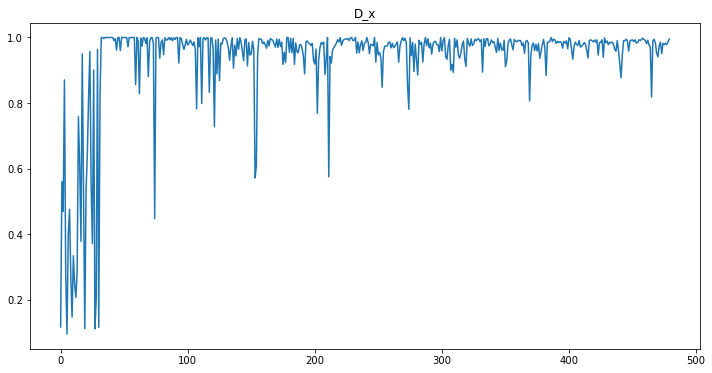

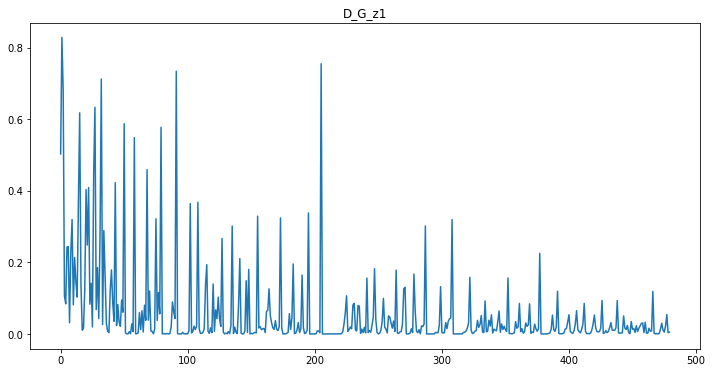

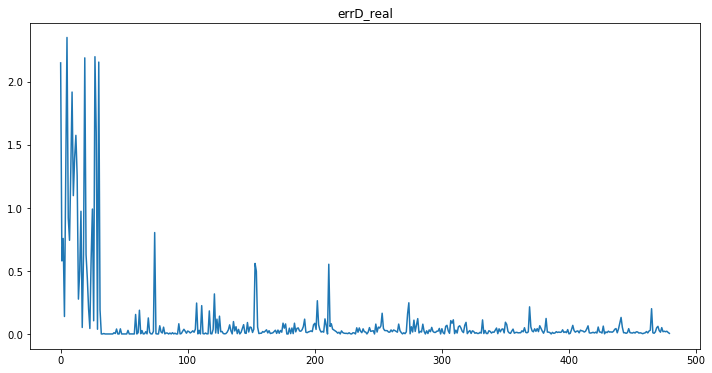

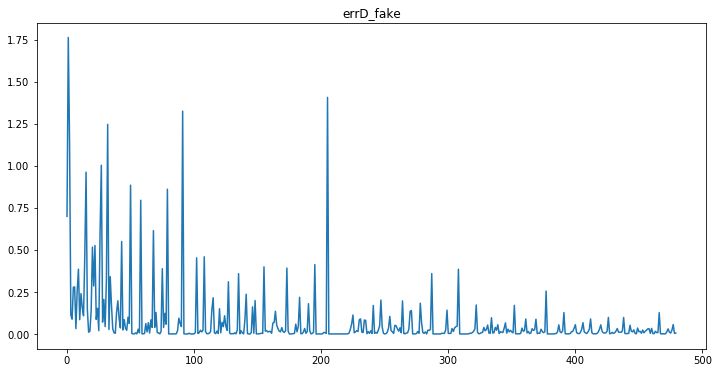

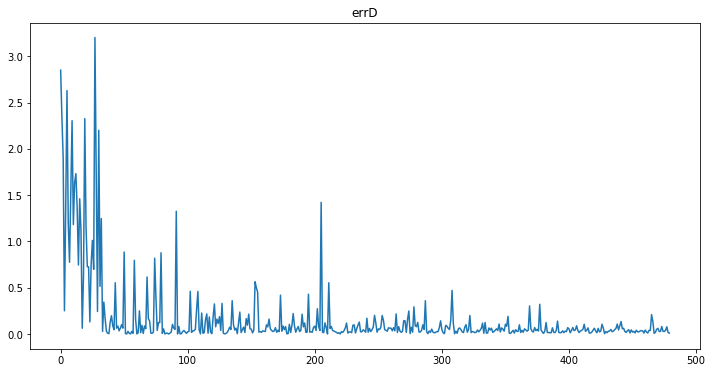

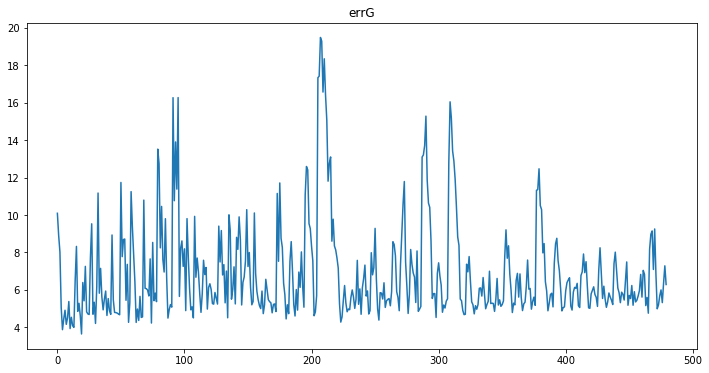

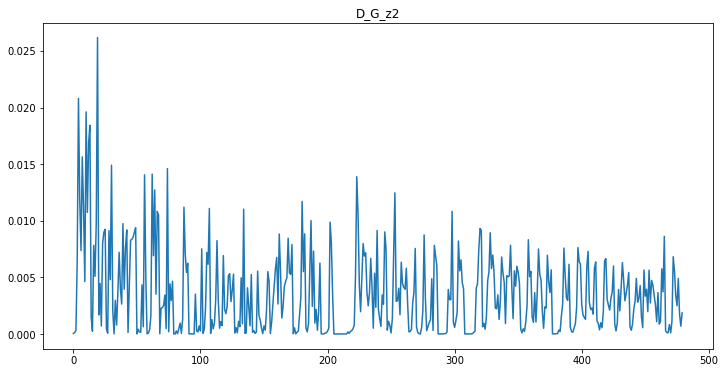

D_x = 0.9885391592979431
Forward Propagation of Generator
D_G_z1 = 0.006074242759495974
errD = errD_real + errD_fake = tensor(0.0176, grad_fn=<ThAddBackward>)
[15/25][0/32] Loss_D: 0.0176 Loss_G: 5.8818 D(x): 0.9885 D(G(z)): 0.0061 / 0.0028
D_x = 0.9892218112945557
Forward Propagation of Generator
D_G_z1 = 0.006388012319803238
errD = errD_real + errD_fake = tensor(0.0172, grad_fn=<ThAddBackward>)
[15/25][1/32] Loss_D: 0.0172 Loss_G: 5.7257 D(x): 0.9892 D(G(z)): 0.0064 / 0.0033
D_x = 0.9948339462280273
Forward Propagation of Generator
D_G_z1 = 0.014774749055504799
errD = errD_real + errD_fake = tensor(0.0201, grad_fn=<ThAddBackward>)
[15/25][2/32] Loss_D: 0.0201 Loss_G: 5.3105 D(x): 0.9948 D(G(z)): 0.0148 / 0.0049
D_x = 0.986645519733429
Forward Propagation of Generator
D_G_z1 = 0.045900989323854446
errD = errD_real + errD_fake = tensor(0.0604, grad_fn=<ThAddBackward>)
[15/25][3/32] Loss_D: 0.0604 Loss_G: 6.0905 D(x): 0.9866 D(G(z)): 0.0459 / 0.0023
D_x = 0.9932025671005249
Forward Prop

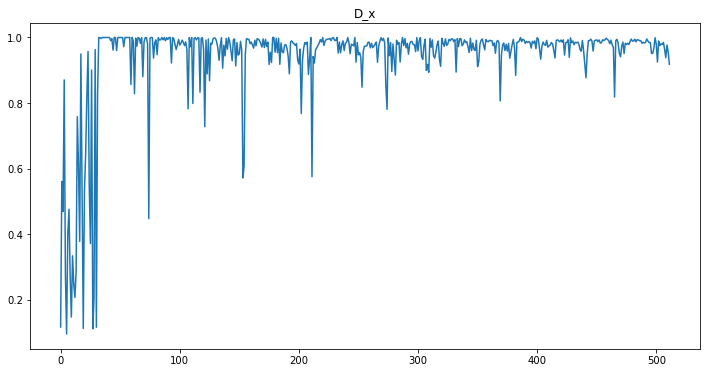

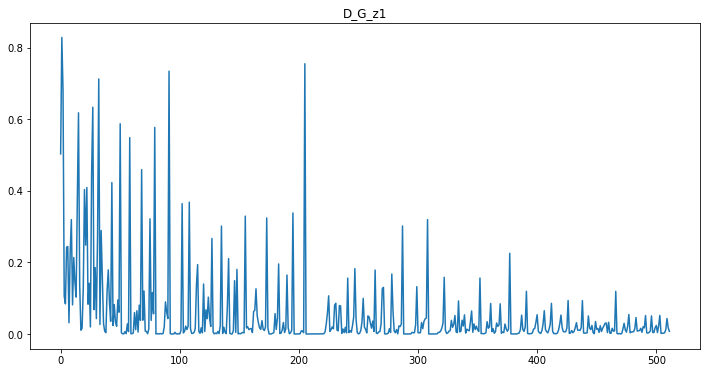

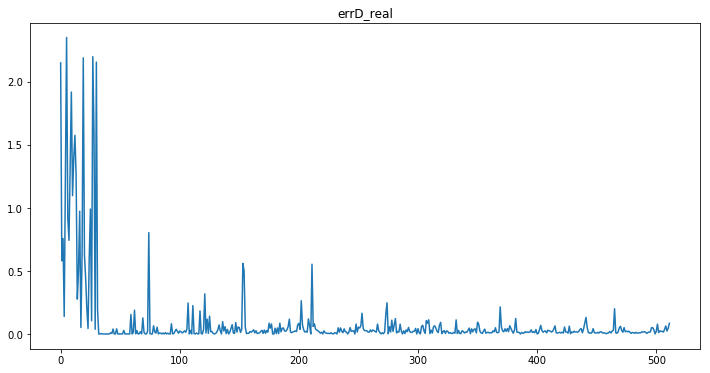

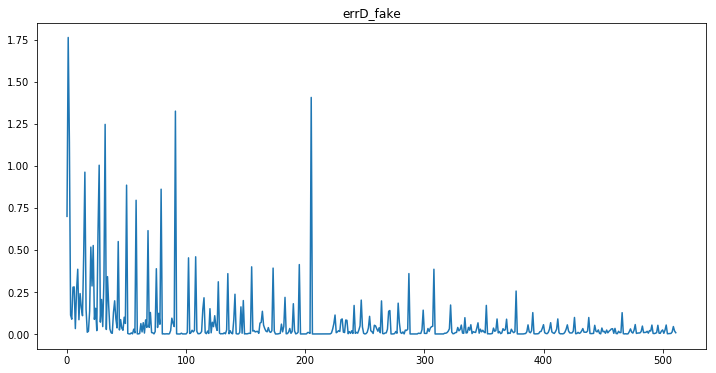

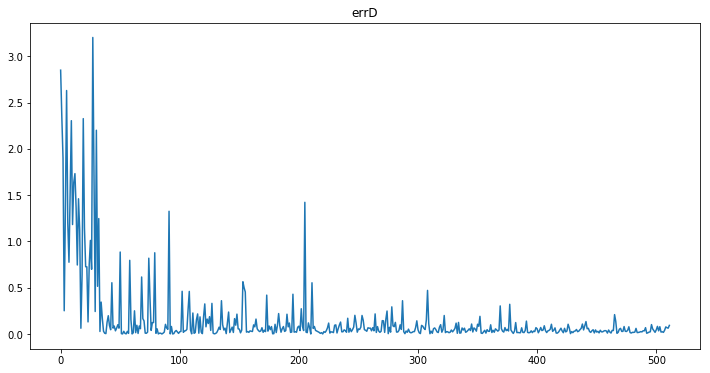

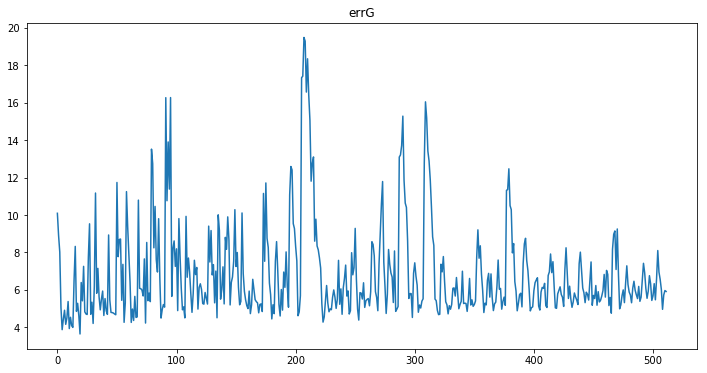

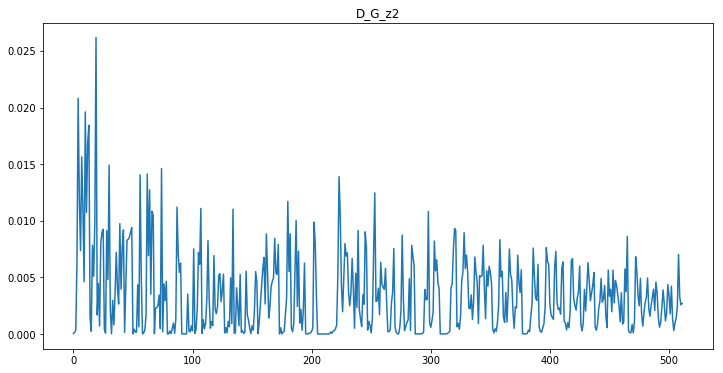

D_x = 0.9927687644958496
Forward Propagation of Generator
D_G_z1 = 0.0244627445936203
errD = errD_real + errD_fake = tensor(0.0320, grad_fn=<ThAddBackward>)
[16/25][0/32] Loss_D: 0.0320 Loss_G: 5.4996 D(x): 0.9928 D(G(z)): 0.0245 / 0.0041
D_x = 0.9878707528114319
Forward Propagation of Generator
D_G_z1 = 0.022412089630961418
errD = errD_real + errD_fake = tensor(0.0349, grad_fn=<ThAddBackward>)
[16/25][1/32] Loss_D: 0.0349 Loss_G: 5.7842 D(x): 0.9879 D(G(z)): 0.0224 / 0.0031
D_x = 0.979814887046814
Forward Propagation of Generator
D_G_z1 = 0.00559048168361187
errD = errD_real + errD_fake = tensor(0.0260, grad_fn=<ThAddBackward>)
[16/25][2/32] Loss_D: 0.0260 Loss_G: 6.2831 D(x): 0.9798 D(G(z)): 0.0056 / 0.0019
D_x = 0.9781185984611511
Forward Propagation of Generator
D_G_z1 = 0.008510160259902477
errD = errD_real + errD_fake = tensor(0.0307, grad_fn=<ThAddBackward>)
[16/25][3/32] Loss_D: 0.0307 Loss_G: 5.6975 D(x): 0.9781 D(G(z)): 0.0085 / 0.0034
D_x = 0.998620867729187
Forward Propagat

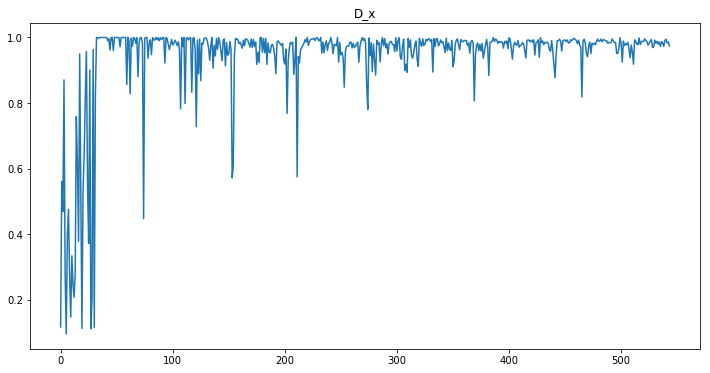

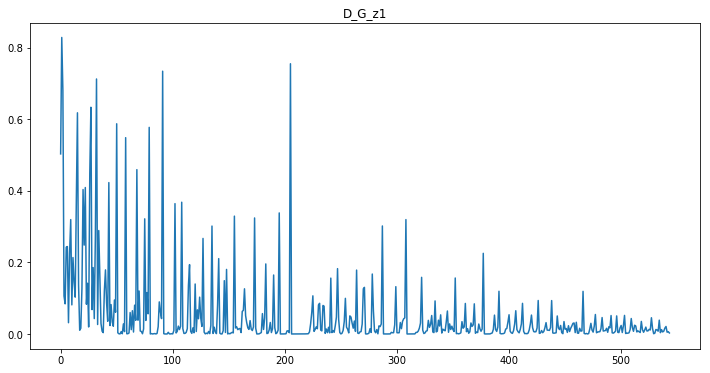

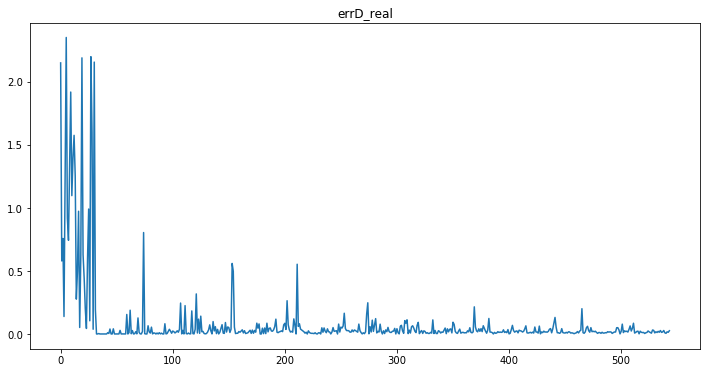

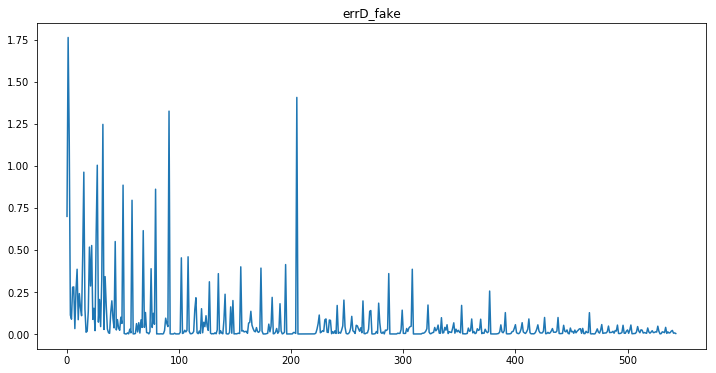

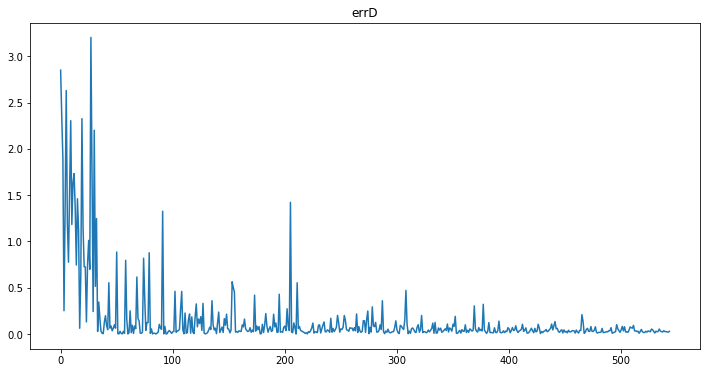

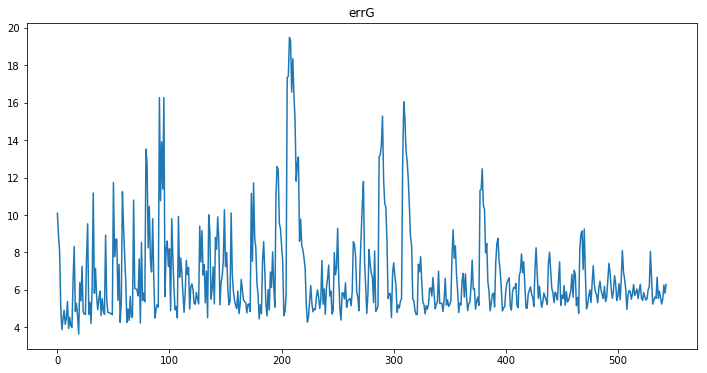

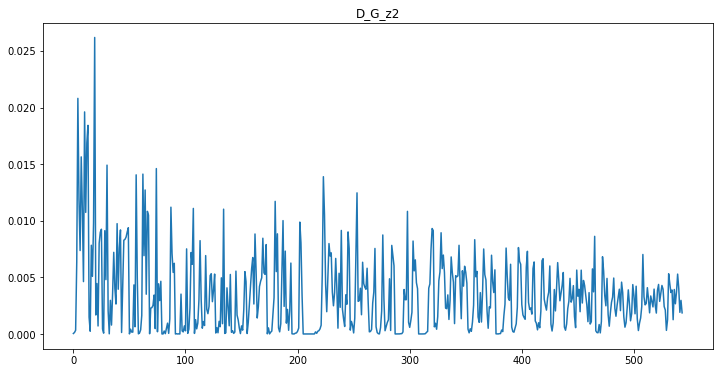

D_x = 0.9959164261817932
Forward Propagation of Generator
D_G_z1 = 0.009616298601031303
errD = errD_real + errD_fake = tensor(0.0138, grad_fn=<ThAddBackward>)
[17/25][0/32] Loss_D: 0.0138 Loss_G: 5.3468 D(x): 0.9959 D(G(z)): 0.0096 / 0.0048
D_x = 0.9765922427177429
Forward Propagation of Generator
D_G_z1 = 0.009208808653056622
errD = errD_real + errD_fake = tensor(0.0329, grad_fn=<ThAddBackward>)
[17/25][1/32] Loss_D: 0.0329 Loss_G: 5.4469 D(x): 0.9766 D(G(z)): 0.0092 / 0.0043
D_x = 0.9914622902870178
Forward Propagation of Generator
D_G_z1 = 0.024761252105236053
errD = errD_real + errD_fake = tensor(0.0336, grad_fn=<ThAddBackward>)
[17/25][2/32] Loss_D: 0.0336 Loss_G: 5.3222 D(x): 0.9915 D(G(z)): 0.0248 / 0.0049
D_x = 0.9952582716941833
Forward Propagation of Generator
D_G_z1 = 0.021915875375270844
errD = errD_real + errD_fake = tensor(0.0269, grad_fn=<ThAddBackward>)
[17/25][3/32] Loss_D: 0.0269 Loss_G: 5.6390 D(x): 0.9953 D(G(z)): 0.0219 / 0.0036
D_x = 0.9924554824829102
Forward Pro

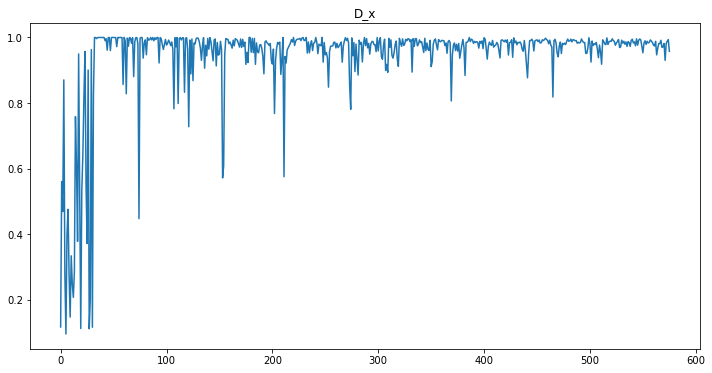

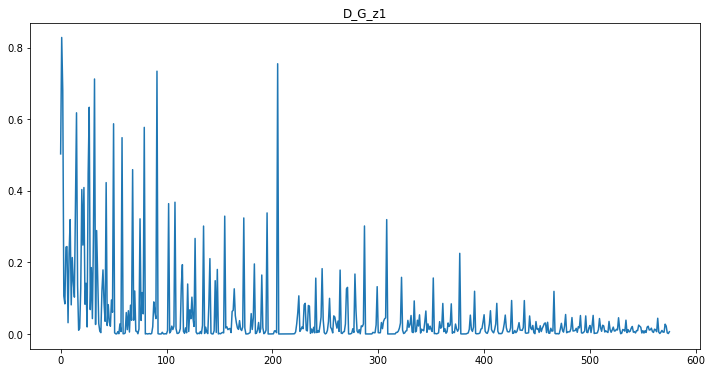

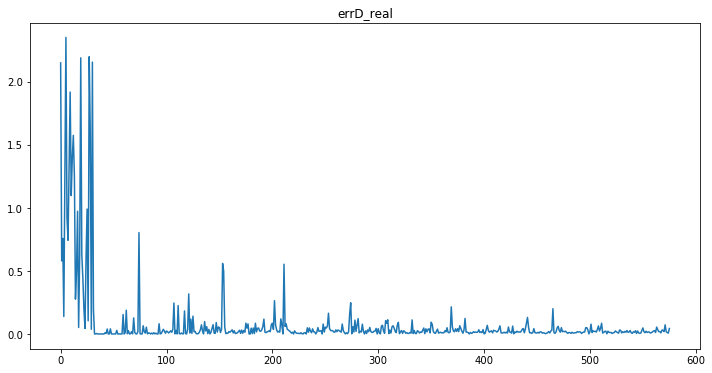

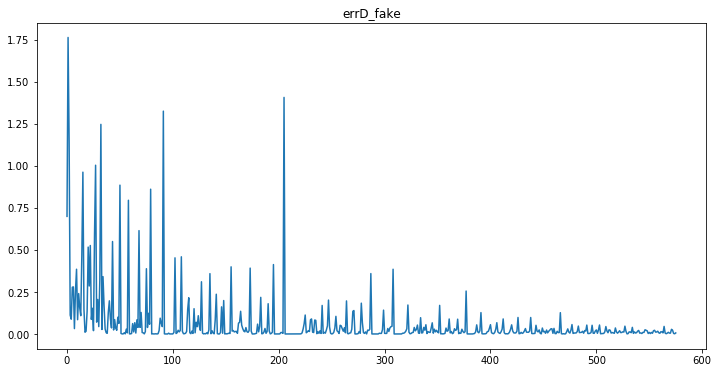

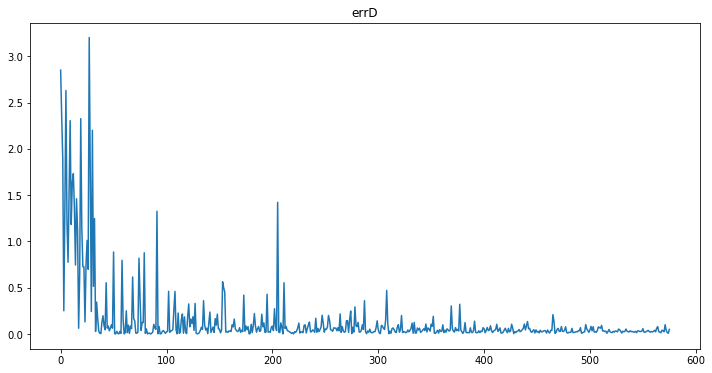

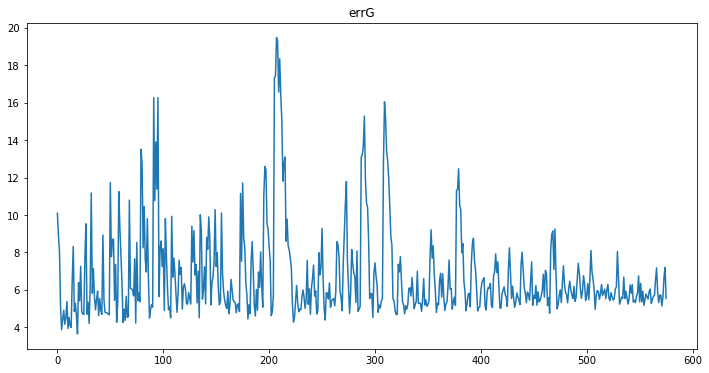

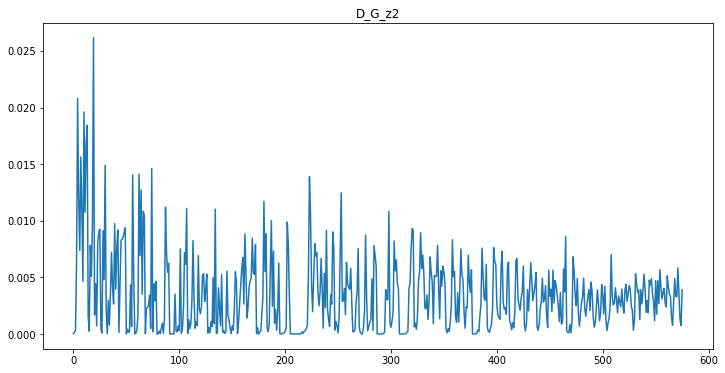

D_x = 0.9941755533218384
Forward Propagation of Generator
D_G_z1 = 0.008543498814105988
errD = errD_real + errD_fake = tensor(0.0144, grad_fn=<ThAddBackward>)
[18/25][0/32] Loss_D: 0.0144 Loss_G: 5.4291 D(x): 0.9942 D(G(z)): 0.0085 / 0.0044
D_x = 0.9932575225830078
Forward Propagation of Generator
D_G_z1 = 0.044017888605594635
errD = errD_real + errD_fake = tensor(0.0518, grad_fn=<ThAddBackward>)
[18/25][1/32] Loss_D: 0.0518 Loss_G: 5.7879 D(x): 0.9933 D(G(z)): 0.0440 / 0.0031
D_x = 0.9904470443725586
Forward Propagation of Generator
D_G_z1 = 0.011730977334082127
errD = errD_real + errD_fake = tensor(0.0214, grad_fn=<ThAddBackward>)
[18/25][2/32] Loss_D: 0.0214 Loss_G: 6.1460 D(x): 0.9904 D(G(z)): 0.0117 / 0.0021
D_x = 0.9912760257720947
Forward Propagation of Generator
D_G_z1 = 0.0011301866034045815
errD = errD_real + errD_fake = tensor(0.0099, grad_fn=<ThAddBackward>)
[18/25][3/32] Loss_D: 0.0099 Loss_G: 7.5961 D(x): 0.9913 D(G(z)): 0.0011 / 0.0005
D_x = 0.99265056848526
Forward Prop

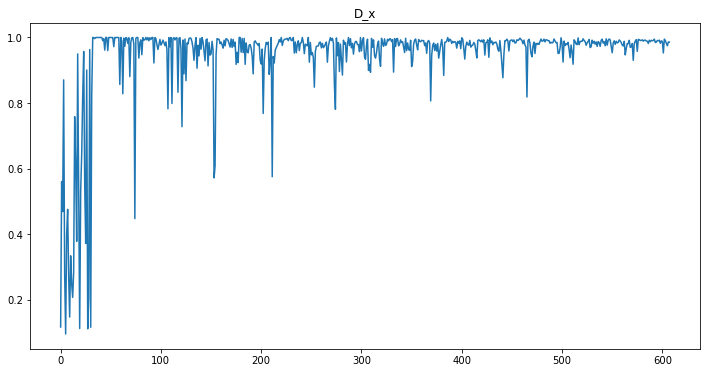

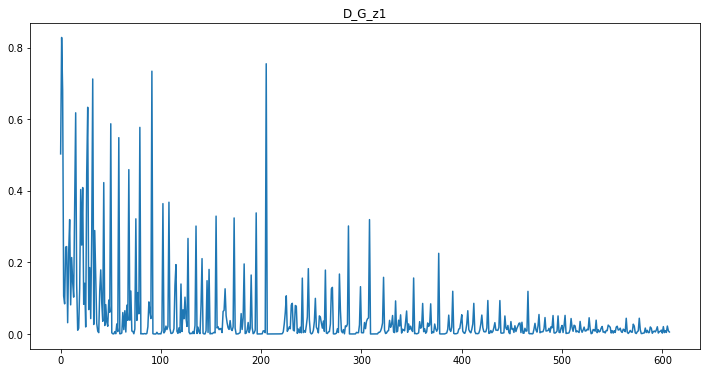

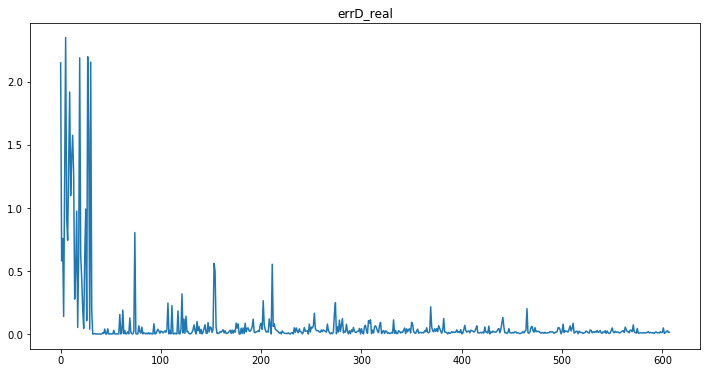

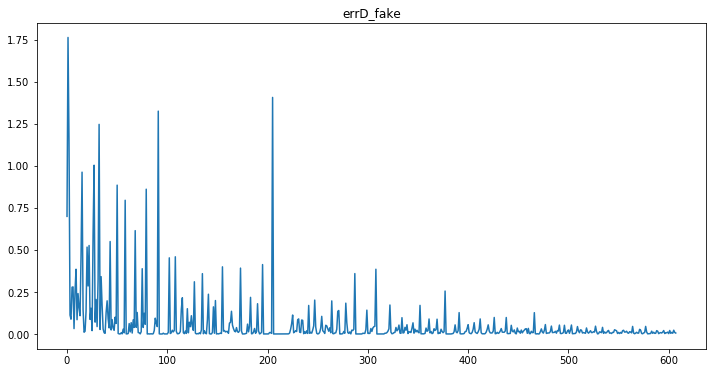

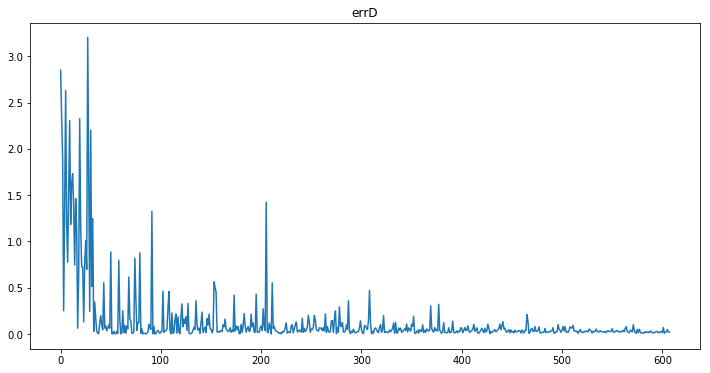

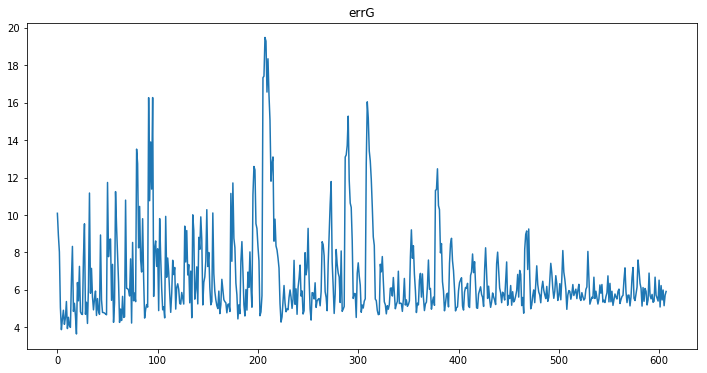

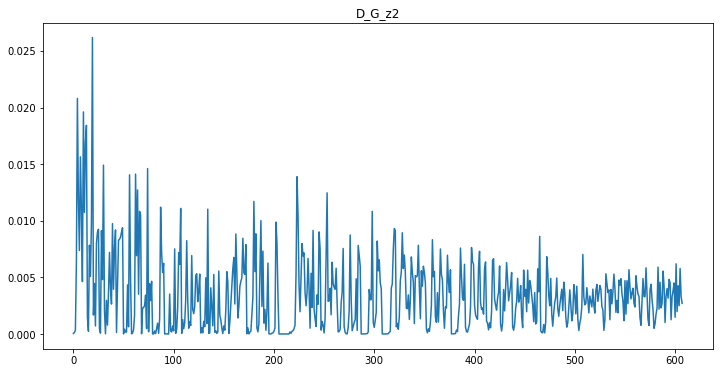

D_x = 0.9934101700782776
Forward Propagation of Generator
D_G_z1 = 0.007552257739007473
errD = errD_real + errD_fake = tensor(0.0142, grad_fn=<ThAddBackward>)
[19/25][0/32] Loss_D: 0.0142 Loss_G: 5.6170 D(x): 0.9934 D(G(z)): 0.0076 / 0.0036
D_x = 0.9882016777992249
Forward Propagation of Generator
D_G_z1 = 0.0015158549649640918
errD = errD_real + errD_fake = tensor(0.0134, grad_fn=<ThAddBackward>)
[19/25][1/32] Loss_D: 0.0134 Loss_G: 6.8595 D(x): 0.9882 D(G(z)): 0.0015 / 0.0010
D_x = 0.9911818504333496
Forward Propagation of Generator
D_G_z1 = 0.005445179995149374
errD = errD_real + errD_fake = tensor(0.0143, grad_fn=<ThAddBackward>)
[19/25][2/32] Loss_D: 0.0143 Loss_G: 5.6736 D(x): 0.9912 D(G(z)): 0.0054 / 0.0034
D_x = 0.991216778755188
Forward Propagation of Generator
D_G_z1 = 0.004535948392003775
errD = errD_real + errD_fake = tensor(0.0134, grad_fn=<ThAddBackward>)
[19/25][3/32] Loss_D: 0.0134 Loss_G: 5.8215 D(x): 0.9912 D(G(z)): 0.0045 / 0.0030
D_x = 0.9926196932792664
Forward Pro

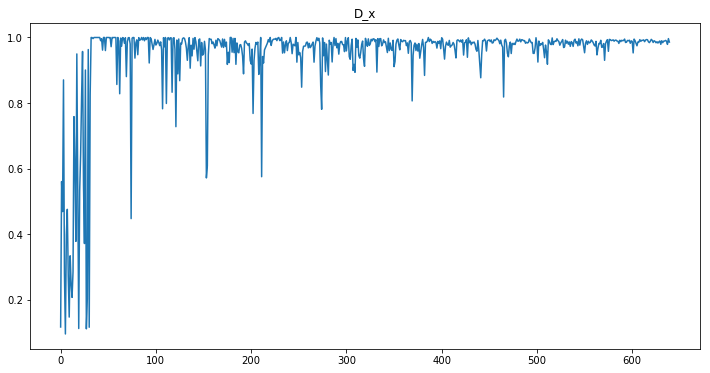

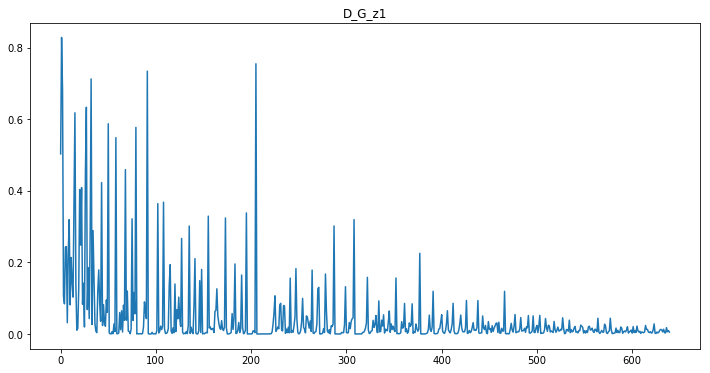

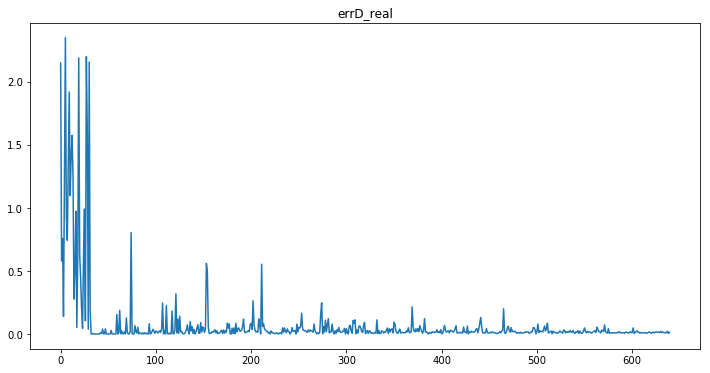

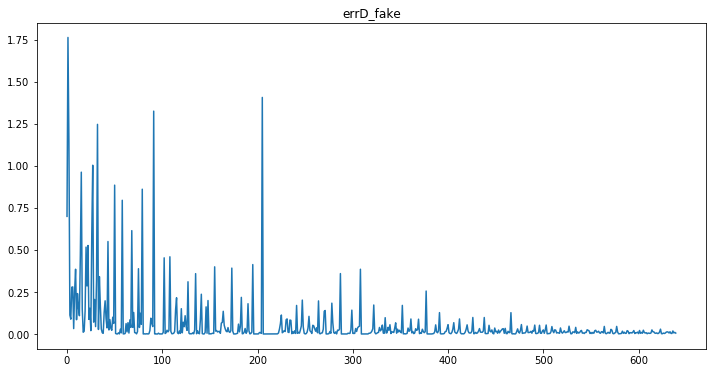

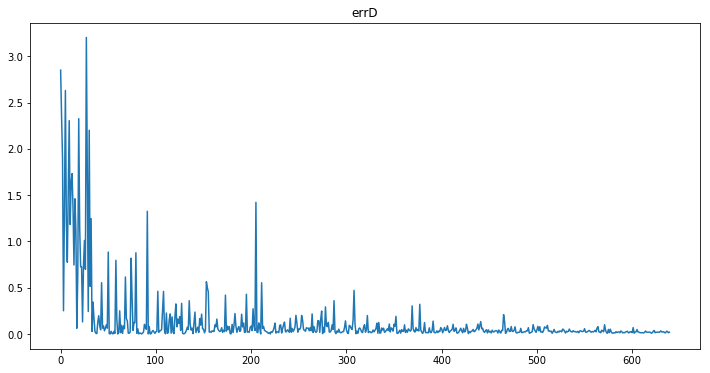

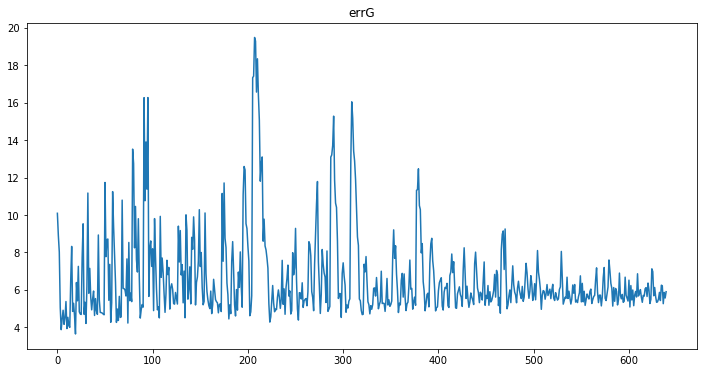

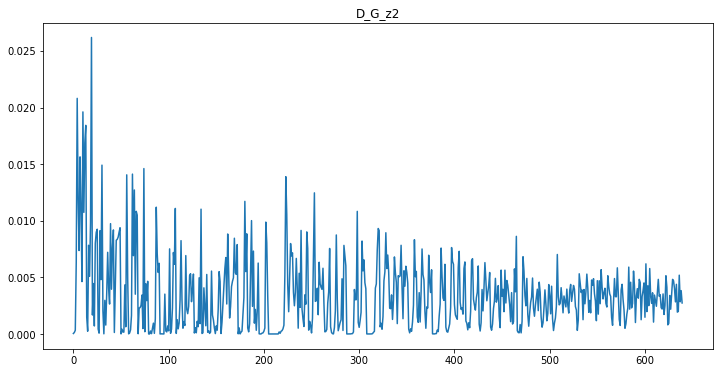

D_x = 0.9908164739608765
Forward Propagation of Generator
D_G_z1 = 0.0039017400704324245
errD = errD_real + errD_fake = tensor(0.0131, grad_fn=<ThAddBackward>)
[20/25][0/32] Loss_D: 0.0131 Loss_G: 6.0495 D(x): 0.9908 D(G(z)): 0.0039 / 0.0024
D_x = 0.9971429705619812
Forward Propagation of Generator
D_G_z1 = 0.007820767350494862
errD = errD_real + errD_fake = tensor(0.0107, grad_fn=<ThAddBackward>)
[20/25][1/32] Loss_D: 0.0107 Loss_G: 5.5130 D(x): 0.9971 D(G(z)): 0.0078 / 0.0040
D_x = 0.9874780178070068
Forward Propagation of Generator
D_G_z1 = 0.012004912830889225
errD = errD_real + errD_fake = tensor(0.0247, grad_fn=<ThAddBackward>)
[20/25][2/32] Loss_D: 0.0247 Loss_G: 5.4246 D(x): 0.9875 D(G(z)): 0.0120 / 0.0044
D_x = 0.994276225566864
Forward Propagation of Generator
D_G_z1 = 0.010061911307275295
errD = errD_real + errD_fake = tensor(0.0159, grad_fn=<ThAddBackward>)
[20/25][3/32] Loss_D: 0.0159 Loss_G: 5.5595 D(x): 0.9943 D(G(z)): 0.0101 / 0.0039
D_x = 0.9922009706497192
Forward Pro

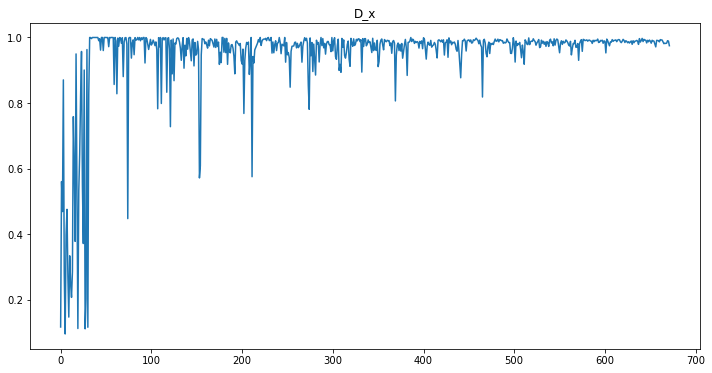

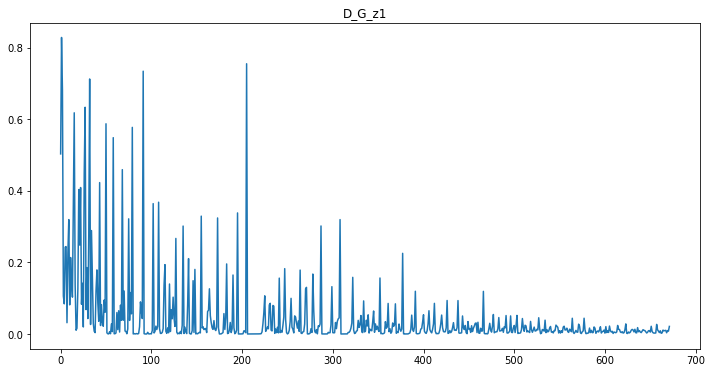

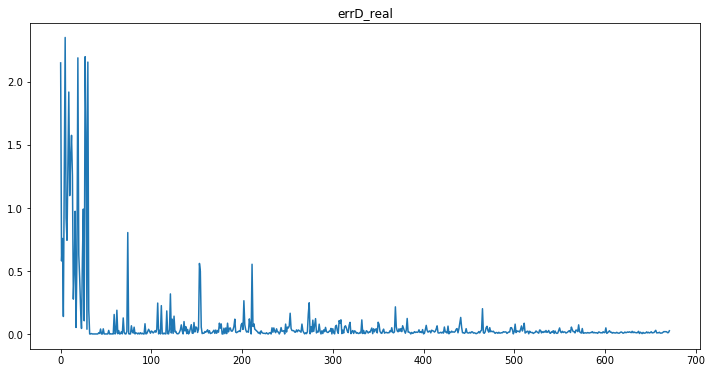

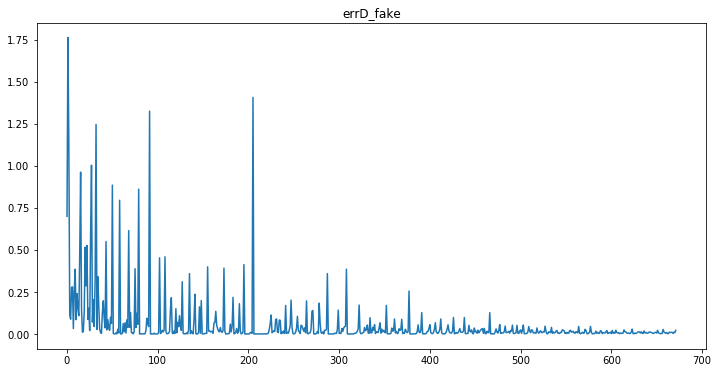

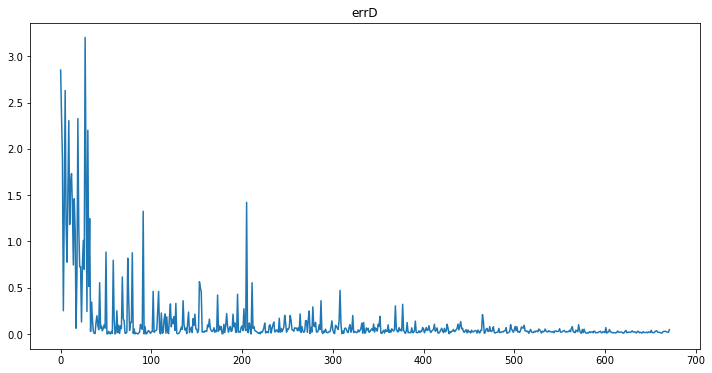

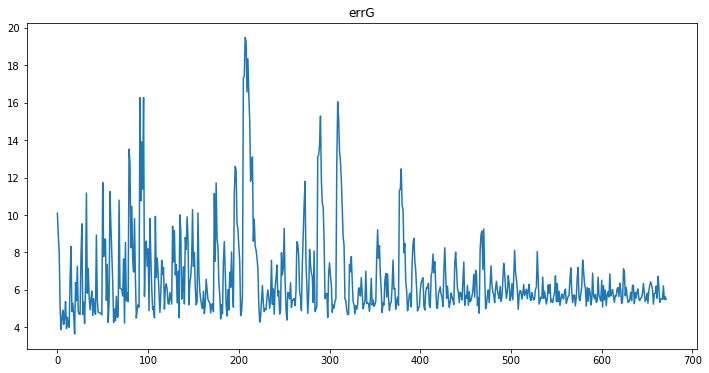

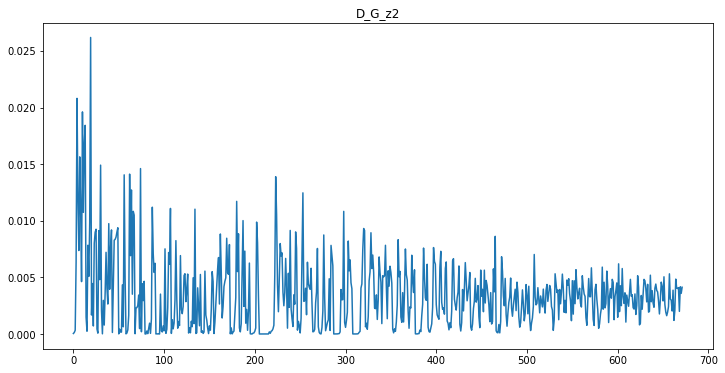

D_x = 0.9917987585067749
Forward Propagation of Generator
D_G_z1 = 0.010581974871456623
errD = errD_real + errD_fake = tensor(0.0189, grad_fn=<ThAddBackward>)
[21/25][0/32] Loss_D: 0.0189 Loss_G: 5.8578 D(x): 0.9918 D(G(z)): 0.0106 / 0.0029
D_x = 0.9938971400260925
Forward Propagation of Generator
D_G_z1 = 0.0053788782097399235
errD = errD_real + errD_fake = tensor(0.0115, grad_fn=<ThAddBackward>)
[21/25][1/32] Loss_D: 0.0115 Loss_G: 6.0906 D(x): 0.9939 D(G(z)): 0.0054 / 0.0023
D_x = 0.9923081398010254
Forward Propagation of Generator
D_G_z1 = 0.0019558363128453493
errD = errD_real + errD_fake = tensor(0.0097, grad_fn=<ThAddBackward>)
[21/25][2/32] Loss_D: 0.0097 Loss_G: 6.7347 D(x): 0.9923 D(G(z)): 0.0020 / 0.0012
D_x = 0.9915561676025391
Forward Propagation of Generator
D_G_z1 = 0.012311479076743126
errD = errD_real + errD_fake = tensor(0.0209, grad_fn=<ThAddBackward>)
[21/25][3/32] Loss_D: 0.0209 Loss_G: 5.3715 D(x): 0.9916 D(G(z)): 0.0123 / 0.0046
D_x = 0.988896369934082
Forward Pr

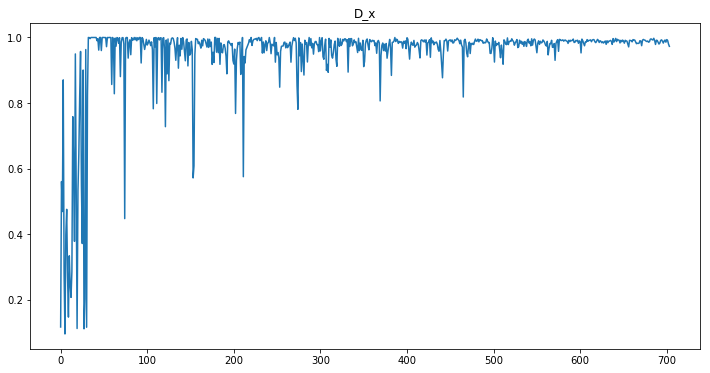

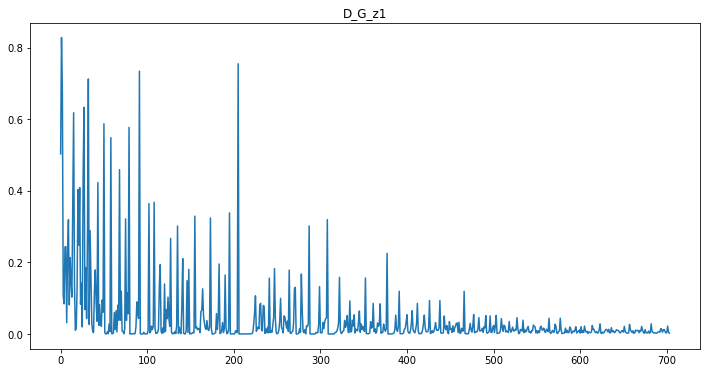

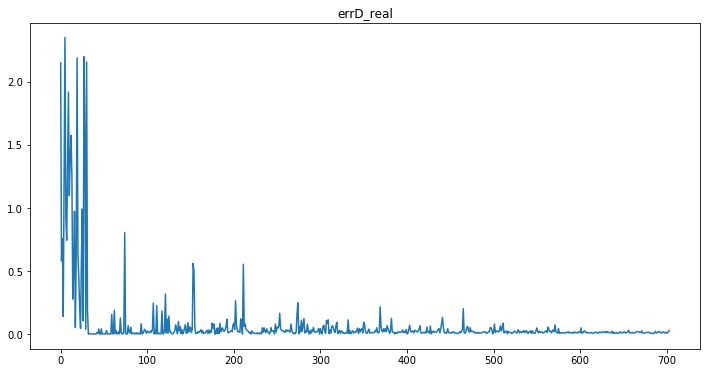

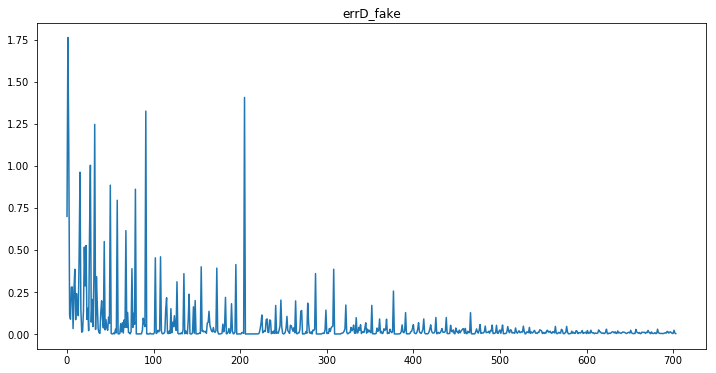

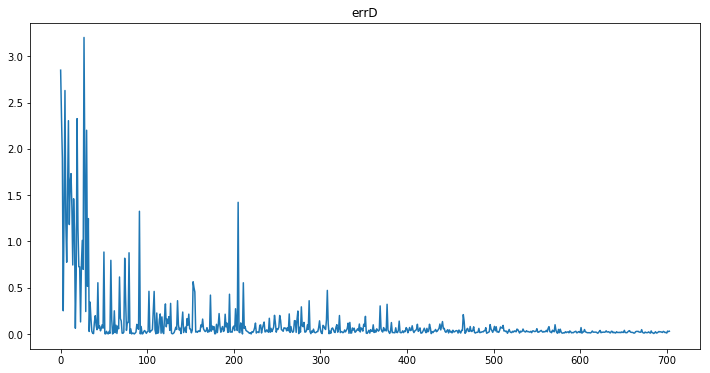

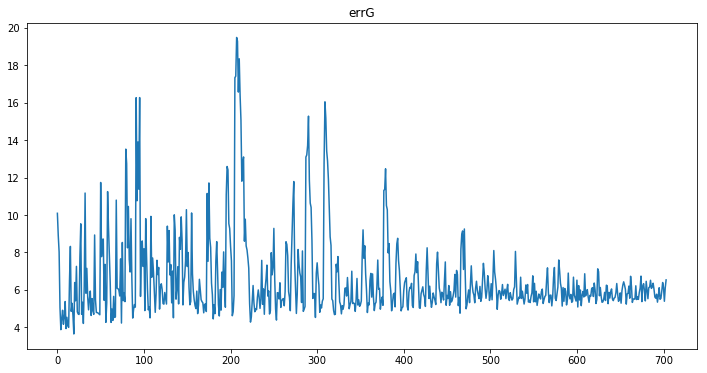

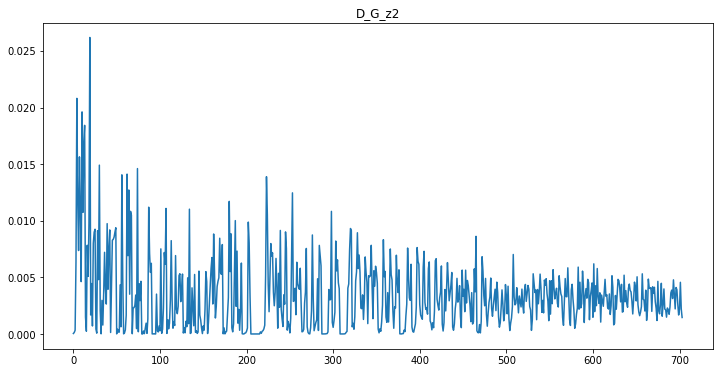

D_x = 0.9901727437973022
Forward Propagation of Generator
D_G_z1 = 0.0009972535772249103
errD = errD_real + errD_fake = tensor(0.0109, grad_fn=<ThAddBackward>)
[22/25][0/32] Loss_D: 0.0109 Loss_G: 7.1495 D(x): 0.9902 D(G(z)): 0.0010 / 0.0008
D_x = 0.9937713742256165
Forward Propagation of Generator
D_G_z1 = 0.0027526516932994127
errD = errD_real + errD_fake = tensor(0.0090, grad_fn=<ThAddBackward>)
[22/25][1/32] Loss_D: 0.0090 Loss_G: 6.1688 D(x): 0.9938 D(G(z)): 0.0028 / 0.0021
D_x = 0.9935094714164734
Forward Propagation of Generator
D_G_z1 = 0.0017090654000639915
errD = errD_real + errD_fake = tensor(0.0082, grad_fn=<ThAddBackward>)
[22/25][2/32] Loss_D: 0.0082 Loss_G: 6.5821 D(x): 0.9935 D(G(z)): 0.0017 / 0.0014
D_x = 0.9835017323493958
Forward Propagation of Generator
D_G_z1 = 0.008720027282834053
errD = errD_real + errD_fake = tensor(0.0254, grad_fn=<ThAddBackward>)
[22/25][3/32] Loss_D: 0.0254 Loss_G: 5.3415 D(x): 0.9835 D(G(z)): 0.0087 / 0.0048
D_x = 0.9942179918289185
Forward 

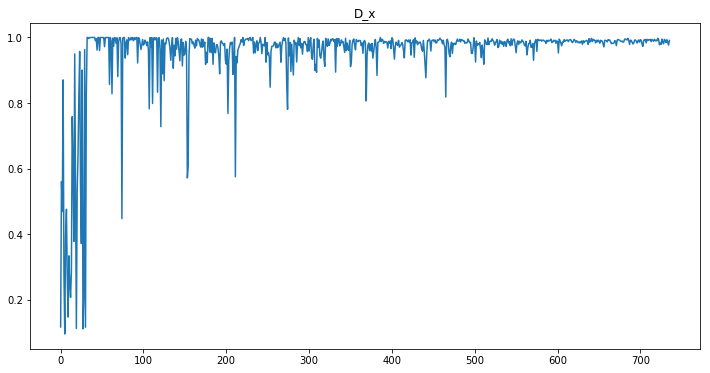

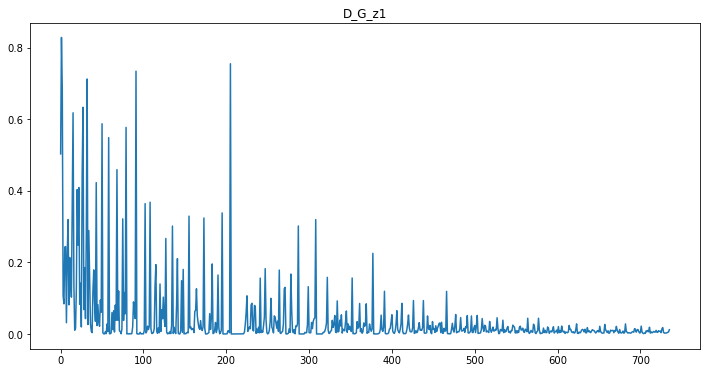

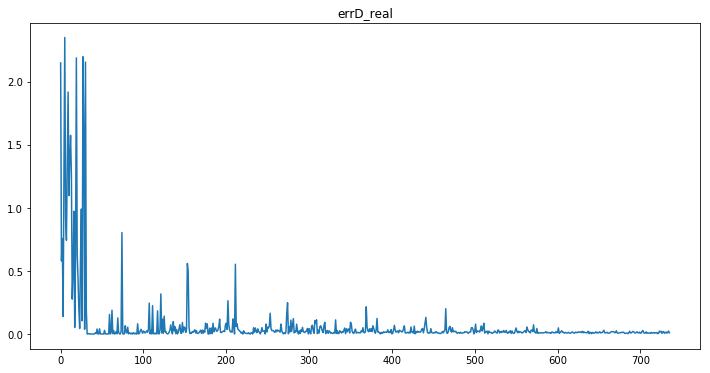

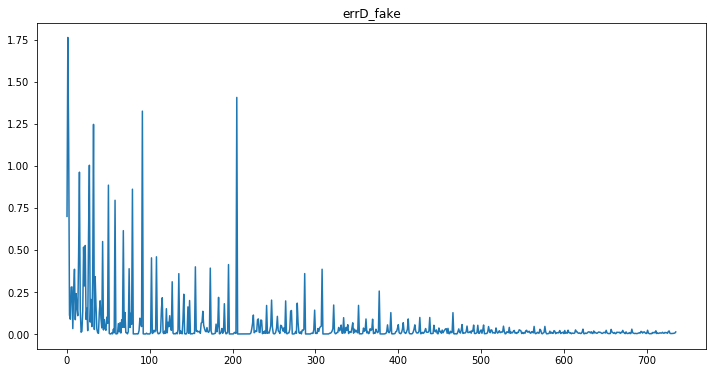

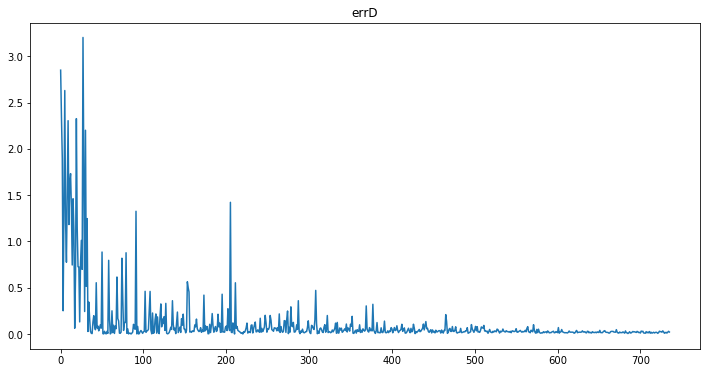

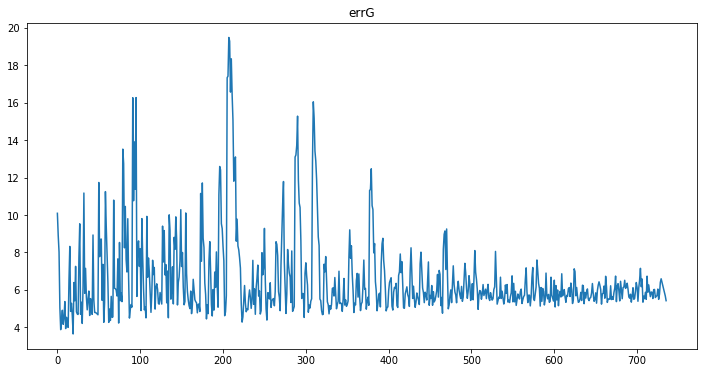

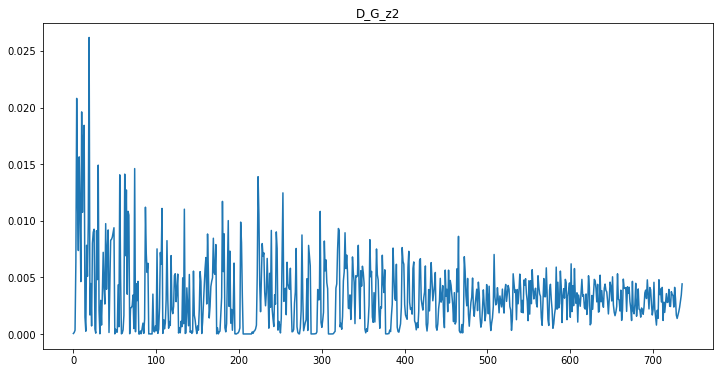

D_x = 0.9907129406929016
Forward Propagation of Generator
D_G_z1 = 0.00632551359012723
errD = errD_real + errD_fake = tensor(0.0157, grad_fn=<ThAddBackward>)
[23/25][0/32] Loss_D: 0.0157 Loss_G: 5.8665 D(x): 0.9907 D(G(z)): 0.0063 / 0.0028
D_x = 0.9928981065750122
Forward Propagation of Generator
D_G_z1 = 0.004158676136285067
errD = errD_real + errD_fake = tensor(0.0113, grad_fn=<ThAddBackward>)
[23/25][1/32] Loss_D: 0.0113 Loss_G: 6.1297 D(x): 0.9929 D(G(z)): 0.0042 / 0.0022
D_x = 0.9943656921386719
Forward Propagation of Generator
D_G_z1 = 0.003731973934918642
errD = errD_real + errD_fake = tensor(0.0094, grad_fn=<ThAddBackward>)
[23/25][2/32] Loss_D: 0.0094 Loss_G: 6.1533 D(x): 0.9944 D(G(z)): 0.0037 / 0.0021
D_x = 0.9920592308044434
Forward Propagation of Generator
D_G_z1 = 0.0007480700151063502
errD = errD_real + errD_fake = tensor(0.0087, grad_fn=<ThAddBackward>)
[23/25][3/32] Loss_D: 0.0087 Loss_G: 7.4629 D(x): 0.9921 D(G(z)): 0.0007 / 0.0006
D_x = 0.9950447082519531
Forward Pro

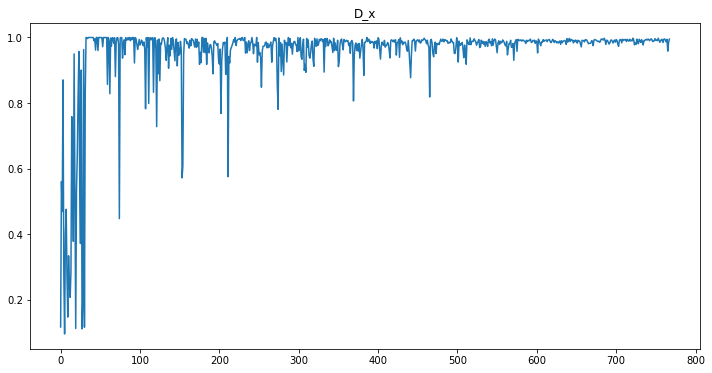

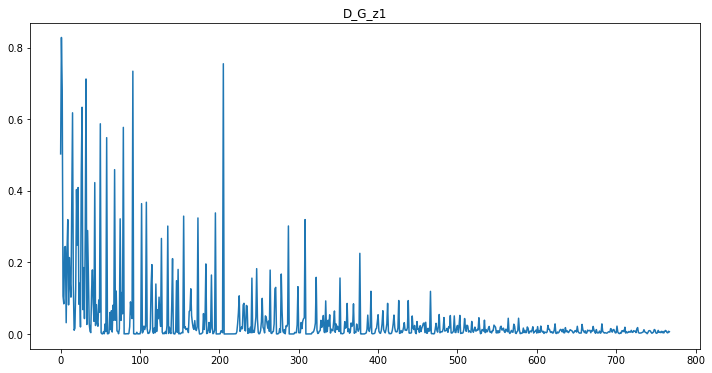

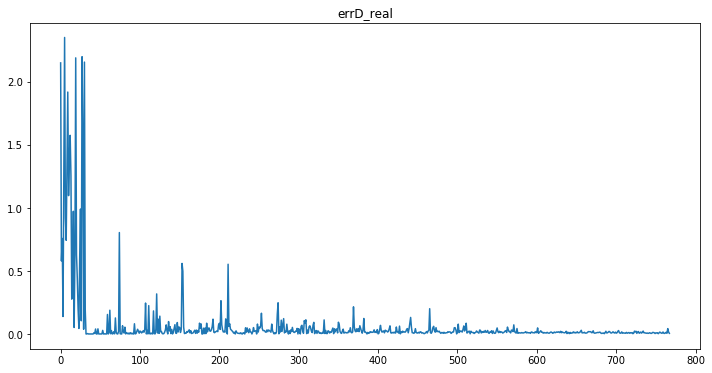

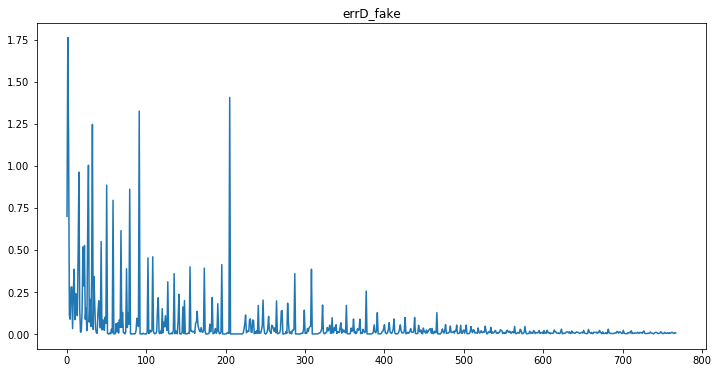

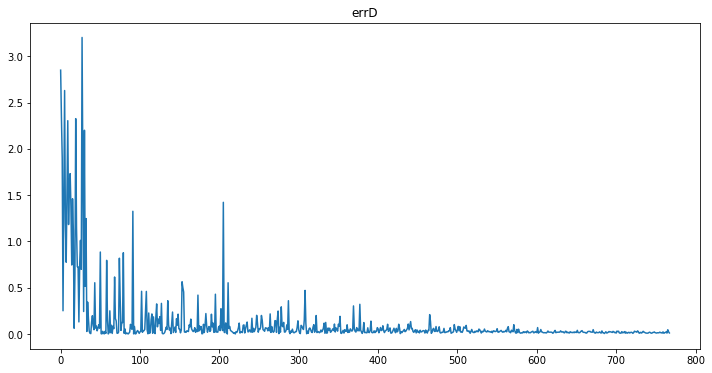

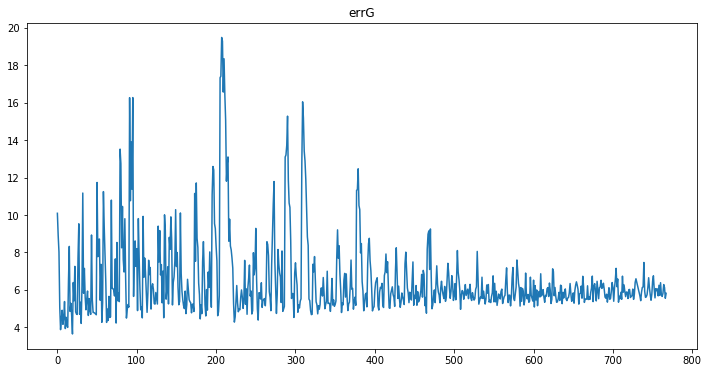

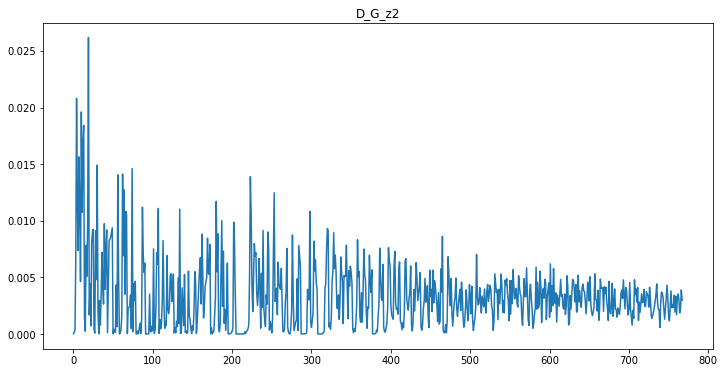

D_x = 0.9944480657577515
Forward Propagation of Generator
D_G_z1 = 0.0030272032599896193
errD = errD_real + errD_fake = tensor(0.0086, grad_fn=<ThAddBackward>)
[24/25][0/32] Loss_D: 0.0086 Loss_G: 6.3368 D(x): 0.9944 D(G(z)): 0.0030 / 0.0018
D_x = 0.9965081810951233
Forward Propagation of Generator
D_G_z1 = 0.00683968560770154
errD = errD_real + errD_fake = tensor(0.0104, grad_fn=<ThAddBackward>)
[24/25][1/32] Loss_D: 0.0104 Loss_G: 5.8112 D(x): 0.9965 D(G(z)): 0.0068 / 0.0030
D_x = 0.9912876486778259
Forward Propagation of Generator
D_G_z1 = 0.0017464933916926384
errD = errD_real + errD_fake = tensor(0.0105, grad_fn=<ThAddBackward>)
[24/25][2/32] Loss_D: 0.0105 Loss_G: 6.7649 D(x): 0.9913 D(G(z)): 0.0017 / 0.0012
D_x = 0.9953172206878662
Forward Propagation of Generator
D_G_z1 = 0.002279803156852722
errD = errD_real + errD_fake = tensor(0.0070, grad_fn=<ThAddBackward>)
[24/25][3/32] Loss_D: 0.0070 Loss_G: 6.4552 D(x): 0.9953 D(G(z)): 0.0023 / 0.0016
D_x = 0.9956375956535339
Forward Pr

In [82]:
D_x_list = []
D_G_z1_list = []
errD_real_list = []
errD_fake_list = []
errD_list = []
errG_list = []
D_G_z2_list = []
real_batch_sum_list = []
fake_batch_sum_list = []


# initializing losses for use in if statement
# for stopping the training of either
# the Generator or the Discriminator



errD_limit = 0.5
errG_limit = 0.05

train_discriminator = True
train_generator = True


#for epoch in range(opt.niter):
for epoch in range(niter):
    
    print("\n --------------------------------------")
    print("Epoch = " +str(epoch) + " / " + str(niter))
    print("-------------------------------------- \n")
    
    if epoch != 0:
        
        
        plt.figure(figsize=(12,6))
        plt.title("D_x")
        plt.plot(D_x_list)
        plt.show()
        
        plt.figure(figsize=(12,6))
        plt.title("D_G_z1")
        plt.plot(D_G_z1_list)
        plt.show()
        
#         plt.figure(figsize=(12,6))
#         plt.title("errD_real")
#         plt.plot(errD_real_list)
#         plt.show()
        
#         plt.figure(figsize=(12,6))
#         plt.title("errD_fake")
#         plt.plot(errD_fake_list)
#         plt.show()
        
#         plt.figure(figsize=(12,6))
#         plt.title("errD")
#         plt.plot(errD_list)
#         plt.show()
        
#         plt.figure(figsize=(12,6))
#         plt.title("errG")
#         plt.plot(errG_list)
#         plt.show()
        
        plt.figure(figsize=(12,6))
        plt.title("D_G_z2")
        plt.plot(D_G_z2_list)
        plt.show()
        
        """
        Plotting sum of all elements in the real data batch 
        vs the fake (noise) generated batch to see whether the generator
        is learning to make similar cubes
        """
        
        plt.figure(figsize=(12,6))
        plt.title("Sum of all elements in the real subcube batches")
        plt.plot(real_batch_sum_list)
        plt.show()
        
        plt.figure(figsize=(12,6))
        plt.title("Sum of all elements in the noise generated subcube batches")
        plt.plot(fake_batch_sum_list)
        plt.plot([0 for x in range(len(fake_batch_sum_list))], 
                 color = "black")
        plt.show()
    
    
    for i, data in enumerate(dataloader, 0):
        
        
#         print("Data Shape = " + str(data.shape))
        
        if i != 0:
            if (errD.item() / 2.0) > errG:
                train_discriminator = True
            else:
                train_discriminator = False

            if errG > (errD.item() / 2.0):
                train_generator = True
            else:
                train_generator = False



        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
#         print("(1) Update Discriminator network: maximize log(D(x)) + log(1 - D(G(z)))")
        # train with real
#         print("train with real")
        netD.zero_grad()
        #real_cpu = data[0].to(device)
        real_cpu = data.to(device)
        batch_size = real_cpu.size(0)
#         print("batch_size = " + str(batch_size))

#         print("Real data output size = " + str(real_cpu.shape))
#         print("Real data sum of all elements = " + str(torch.sum(real_cpu)))
        real_batch_sum_list.append(torch.sum(real_cpu).item())


        # torch.full -> 
        # Returns a tensor of size size filled with fill_value
        label = torch.full(size = (batch_size,), 
                           fill_value = real_label, 
                           device = device)
#         print("Discriminator real label = " + str(label))

        output = netD(real_cpu)
#         print("Discriminator output shape = " + str(output.shape))


        errD_real = criterion(output, label)
#         print("Discriminator error (input = real) = " + str(errD_real))

        errD_real.backward()

        D_x = output.mean().item()
        D_x_list.append(D_x)
#         print("D_x = " + str(D_x))

        # train with fake
#         print("batch_size = " + str(batch_size))
#         print("nz = " + str(nz))

        # draws from normal distribution (torch.randn)
        noise = torch.randn(batch_size, 
                            nz, 
                            1, 
                            1,
                            1,
                            device=device)
#         print("Noise shape = " + str(noise.shape))


        fake = netG(noise)
#         print("Generator(noise) output size = " + str(fake.shape))
#         print("Generator(noise) sum of all elements = " + str(torch.sum(fake)))
        fake_batch_sum_list.append(torch.sum(fake).item())

        # change label from real label (=1) to fake_label (=0)
        label.fill_(fake_label)

        output = netD(fake.detach())

        # calculate discriminator's error for fake generated input
        errD_fake = criterion(output, label)
#         print("Discriminator error (input = generated by fake noise) = " + \
#               str(errD_fake))


        errD_fake.backward()


        D_G_z1 = output.mean().item()
        D_G_z1_list.append(D_G_z1)
#         print("D_G_z1 = " + str(D_G_z1))

        errD = errD_real + errD_fake
        errD_real_list.append(errD_real)
        errD_fake_list.append(errD_fake)
        errD_list.append(errD)
#         print("errD = errD_real + errD_fake = " + str(errD))

        if train_discriminator == True:
            print("Weight update to DISCRIMINATOR")
            # weight update of the discriminator
            optimizerD.step()

        
     

            
        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################

#         print("(2) Update G network: maximize log(D(G(z)))")
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        output = netD(fake)

        errG = criterion(output, label)
        errG.backward()
        errG_list.append(errG)

        D_G_z2 = output.mean().item()
        D_G_z2_list.append(D_G_z2)

        if train_generator == True:  
            print("Weight update to GENERATOR")
            # Update of the Generators weights
            optimizerG.step()

        
#         print("Finished Batch")
        
        print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
              % (epoch, niter, i, len(dataloader),
                 errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        
        
#         if i % 100 == 0:
#             vutils.save_image(real_cpu,
#                     '%s/real_samples.png' % opt.outf,
#                     normalize=True)
#             fake = netG(fixed_noise)
#             vutils.save_image(fake.detach(),
#                     '%s/fake_samples_epoch_%03d.png' % (opt.outf, epoch),
#                     normalize=True)

    # do checkpointing
#     torch.save(netG.state_dict(), '%s/netG_epoch_%d.pth' % (opt.outf, epoch))
#     torch.save(netD.state_dict(), '%s/netD_epoch_%d.pth' % (opt.outf, epoch))